# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [8]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

print(rides.count())

instant       17379
dteday        17379
season        17379
yr            17379
mnth          17379
hr            17379
holiday       17379
weekday       17379
workingday    17379
weathersit    17379
temp          17379
atemp         17379
hum           17379
windspeed     17379
casual        17379
registered    17379
cnt           17379
dtype: int64


In [9]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

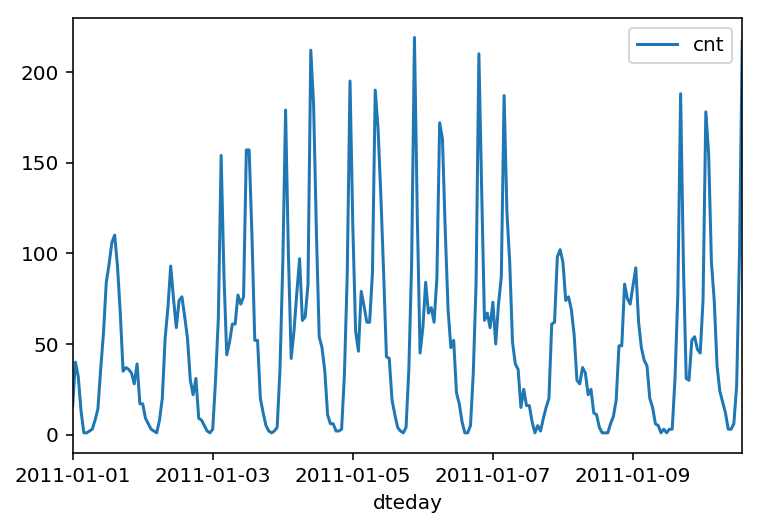

In [10]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [11]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [12]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [13]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [14]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [178]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs =  self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            
            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.  
            
            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            #output_error_term = error * final_outputs * (1 - final_outputs)
            output_error_term = error
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
            
            
            
            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:, None]
            # Weight step (hidden to output)
            print(output_error_term)
            print('******')
            print(hidden_outputs[:, None])
            print('******')
            delta_weights_h_o += output_error_term * hidden_outputs[:, None]


        # TODO: Update the weights - Replace these values with your calculations.
        # update hidden-to-output weights with gradient descent step
        print('LR: ',self.lr)
        print(delta_weights_h_o)
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records
        # update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden +=  self.lr * delta_weights_i_h / n_records
        print(self.weights_hidden_to_output)
        print(self.weights_input_to_hidden)
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [179]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [180]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[ 0.30001076]
******
[[ 0.4850045 ]
 [ 0.45512111]]
******
LR:  0.5
[[ 0.14550657]
 [ 0.13654123]]
[[ 0.37275328]
 [-0.03172939]]
[[ 0.10562014 -0.20185996]
 [ 0.39775194  0.50074398]
 [-0.29887597  0.19962801]]



----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of iterations
This is the number of batches of samples from the training data we'll use to train the network. The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [173]:
import sys

### Set the hyperparameters here ###
iterations = 100
learning_rate = 0.1
hidden_nodes = 2
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[-0.22498073]
******
[[ 0.35648484]
 [ 0.35752488]]
******
[-0.13374589]
******
[[ 0.43915274]
 [ 0.5007739 ]]
******
[-0.07540058]
******
[[ 0.39643422]
 [ 0.64508789]]
******
[-0.162597]
******
[[ 0.26328176]
 [ 0.34816184]]
******
[-0.07984218]
******
[[ 0.43879449]
 [ 0.43607172]]
******
[-0.05564903]
******
[[ 0.42266004]
 [ 0.422455  ]]
******
[ 0.05119882]
******
[[ 0.32343309]
 [ 0.27681662]]
******
[ 0.07303033]
******
[[ 0.67248708]
 [ 0.59389309]]
******
[-0.01781869]
******
[[ 0.46445034]
 [ 0.51696808]]
******
[-0.23420271]
******
[[ 0.45126375]
 [ 0.52720723]]
******
[ 0.00852847]
******
[[ 0.62721922]
 [ 0.68195018]]
******
[-0.10184753]
******
[[ 0.56376178]
 [ 0.52148202]]
******
[-0.12978477]
******
[[ 0.39450956]
 [ 0.34177401]]
******
[-0.0979973]
******
[[ 0.48791637]
 [ 0.4618793 ]]
******
[-0.0908053]
******
[[ 0.47305414]
 [ 0.57701367]]
******
[ 0.00668342]
******
[[ 0.4168415]
 [ 0.5189966]]
******
[ 0.06260945]
******
[[ 0.37499343]
 [ 0.49837162]]
******
[-0

Progress: 0.0% ... Training loss: 1.563 ... Validation loss: 1.471[-0.10947636]
******
[[ 0.4710686 ]
 [ 0.43081499]]
******
[-0.10045178]
******
[[ 0.36936309]
 [ 0.3991836 ]]
******
[-0.37495624]
******
[[ 0.34979396]
 [ 0.61535775]]
******
[-0.37665664]
******
[[ 0.37460215]
 [ 0.4274961 ]]
******
[-0.30686201]
******
[[ 0.4012975 ]
 [ 0.53997419]]
******
[ 0.34219114]
******
[[ 0.29961243]
 [ 0.26600852]]
******
[ 0.10097456]
******
[[ 0.64419458]
 [ 0.51883542]]
******
[-0.27702738]
******
[[ 0.40861798]
 [ 0.37214301]]
******
[-0.26595322]
******
[[ 0.49682251]
 [ 0.50357843]]
******
[ 0.0303071]
******
[[ 0.49969626]
 [ 0.47373226]]
******
[-0.37620444]
******
[[ 0.4198839 ]
 [ 0.61428789]]
******
[-0.20386304]
******
[[ 0.498467  ]
 [ 0.36799187]]
******
[-0.21401579]
******
[[ 0.45927576]
 [ 0.53709814]]
******
[-0.35970247]
******
[[ 0.40092041]
 [ 0.47546838]]
******
[-0.08407661]
******
[[ 0.54564378]
 [ 0.53995539]]
******
[-0.00080363]
******
[[ 0.45193364]
 [ 0.47485162]

Progress: 1.0% ... Training loss: 1.527 ... Validation loss: 1.443[ 0.11990979]
******
[[ 0.36641963]
 [ 0.36555693]]
******
[-0.14957897]
******
[[ 0.48412765]
 [ 0.45155236]]
******
[ 0.22948272]
******
[[ 0.38122051]
 [ 0.32278199]]
******
[-0.08856622]
******
[[ 0.51921202]
 [ 0.53122946]]
******
[-0.12552124]
******
[[ 0.42119883]
 [ 0.32308868]]
******
[-0.18357502]
******
[[ 0.39621388]
 [ 0.34044395]]
******
[-0.22378857]
******
[[ 0.49354181]
 [ 0.38959827]]
******
[ 0.02069751]
******
[[ 0.41496184]
 [ 0.39883882]]
******
[-0.20076437]
******
[[ 0.52547915]
 [ 0.47728585]]
******
[-0.16058847]
******
[[ 0.5763429 ]
 [ 0.70423212]]
******
[ 0.01008799]
******
[[ 0.45828376]
 [ 0.44476947]]
******
[-0.02112068]
******
[[ 0.43475662]
 [ 0.43149942]]
******
[-0.30818181]
******
[[ 0.37650602]
 [ 0.49548571]]
******
[-0.25845862]
******
[[ 0.51859609]
 [ 0.52917927]]
******
[-0.37404274]
******
[[ 0.41596959]
 [ 0.43392502]]
******
[-0.18049915]
******
[[ 0.53895281]
 [ 0.58428054

Progress: 2.0% ... Training loss: 1.480 ... Validation loss: 1.408[-0.22072987]
******
[[ 0.36598708]
 [ 0.47639217]]
******
[-0.21041543]
******
[[ 0.3855251 ]
 [ 0.33258979]]
******
[-0.01969199]
******
[[ 0.59246896]
 [ 0.42664369]]
******
[-0.27855359]
******
[[ 0.42445904]
 [ 0.32011345]]
******
[-0.0365836]
******
[[ 0.56586272]
 [ 0.28518684]]
******
[ 0.13359927]
******
[[ 0.31087538]
 [ 0.36156936]]
******
[-0.0466267]
******
[[ 0.36831016]
 [ 0.36871999]]
******
[-0.18769942]
******
[[ 0.46930513]
 [ 0.42498903]]
******
[ 0.04848406]
******
[[ 0.51355202]
 [ 0.48705942]]
******
[-0.17605488]
******
[[ 0.29971401]
 [ 0.48778615]]
******
[-0.30566517]
******
[[ 0.32206607]
 [ 0.40195233]]
******
[-0.25640138]
******
[[ 0.53429112]
 [ 0.59399966]]
******
[-0.13133145]
******
[[ 0.46348689]
 [ 0.5406992 ]]
******
[ 0.09431352]
******
[[ 0.45829247]
 [ 0.33391672]]
******
[-0.23718525]
******
[[ 0.39981108]
 [ 0.5483717 ]]
******
[-0.10601536]
******
[[ 0.35929457]
 [ 0.2573525 ]]

Progress: 3.0% ... Training loss: 1.442 ... Validation loss: 1.383[-0.11803484]
******
[[ 0.38254465]
 [ 0.43963415]]
******
[ 0.47916572]
******
[[ 0.50827613]
 [ 0.56905224]]
******
[-0.38165787]
******
[[ 0.36269679]
 [ 0.42204003]]
******
[-0.28382481]
******
[[ 0.23890413]
 [ 0.38904904]]
******
[-0.21664032]
******
[[ 0.43316764]
 [ 0.35009724]]
******
[-0.13488066]
******
[[ 0.43309668]
 [ 0.38322505]]
******
[-0.38769006]
******
[[ 0.36809326]
 [ 0.39374786]]
******
[-0.11293577]
******
[[ 0.40430594]
 [ 0.31811023]]
******
[ 0.0007104]
******
[[ 0.44117349]
 [ 0.2881386 ]]
******
[-0.2121561]
******
[[ 0.5232932 ]
 [ 0.58529661]]
******
[-0.085455]
******
[[ 0.38797263]
 [ 0.51787281]]
******
[ 0.55738271]
******
[[ 0.33654931]
 [ 0.52367172]]
******
[ 0.00754091]
******
[[ 0.61695076]
 [ 0.50495907]]
******
[ 0.16565018]
******
[[ 0.41161917]
 [ 0.4538749 ]]
******
[-0.22741535]
******
[[ 0.24915182]
 [ 0.64487168]]
******
[-0.36764861]
******
[[ 0.32576221]
 [ 0.37168835]]
*

Progress: 4.0% ... Training loss: 1.406 ... Validation loss: 1.358[-0.0830118]
******
[[ 0.40458378]
 [ 0.31746245]]
******
[-0.15550974]
******
[[ 0.34145032]
 [ 0.42070187]]
******
[-0.37233598]
******
[[ 0.36879494]
 [ 0.56837749]]
******
[-0.38673168]
******
[[ 0.37390218]
 [ 0.55189887]]
******
[-0.29121814]
******
[[ 0.2257095 ]
 [ 0.35998277]]
******
[-0.14575614]
******
[[ 0.47319838]
 [ 0.2863616 ]]
******
[ 0.29761207]
******
[[ 0.47385757]
 [ 0.59495662]]
******
[-0.29349294]
******
[[ 0.35581919]
 [ 0.48895344]]
******
[-0.24731803]
******
[[ 0.40781495]
 [ 0.42211979]]
******
[-0.26069525]
******
[[ 0.51438741]
 [ 0.47122091]]
******
[-0.31352613]
******
[[ 0.46365912]
 [ 0.38850268]]
******
[ 0.06631396]
******
[[ 0.301129  ]
 [ 0.20660368]]
******
[-0.04890178]
******
[[ 0.34848148]
 [ 0.51952393]]
******
[-0.18487045]
******
[[ 0.50512585]
 [ 0.53650814]]
******
[-0.31522301]
******
[[ 0.38612493]
 [ 0.40106623]]
******
[ 0.27447144]
******
[[ 0.34530262]
 [ 0.35256072]

Progress: 5.0% ... Training loss: 1.366 ... Validation loss: 1.332[ 0.09723534]
******
[[ 0.46763825]
 [ 0.5648316 ]]
******
[ 0.07713736]
******
[[ 0.39963719]
 [ 0.39851339]]
******
[ 0.09104749]
******
[[ 0.2362301 ]
 [ 0.37498414]]
******
[-0.21929153]
******
[[ 0.52025512]
 [ 0.33015561]]
******
[-0.07850688]
******
[[ 0.43926348]
 [ 0.42106407]]
******
[-0.05945381]
******
[[ 0.46031791]
 [ 0.47964347]]
******
[-0.27256054]
******
[[ 0.29523781]
 [ 0.32188235]]
******
[-0.10725731]
******
[[ 0.26894434]
 [ 0.5488682 ]]
******
[-0.15974013]
******
[[ 0.47038893]
 [ 0.61618353]]
******
[-0.30331999]
******
[[ 0.47088366]
 [ 0.55587045]]
******
[ 0.10693632]
******
[[ 0.28578808]
 [ 0.51218613]]
******
[-0.32062683]
******
[[ 0.43680275]
 [ 0.4923524 ]]
******
[-0.2447492]
******
[[ 0.27843808]
 [ 0.5468555 ]]
******
[-0.11569395]
******
[[ 0.43430139]
 [ 0.58991722]]
******
[-0.14785663]
******
[[ 0.39506746]
 [ 0.31846032]]
******
[-0.00020714]
******
[[ 0.63012816]
 [ 0.56437782]

Progress: 6.0% ... Training loss: 1.334 ... Validation loss: 1.312[-0.26132949]
******
[[ 0.5179882]
 [ 0.6847296]]
******
[ 0.55164204]
******
[[ 0.30211138]
 [ 0.57748948]]
******
[-0.00594968]
******
[[ 0.36891298]
 [ 0.31872474]]
******
[-0.21682126]
******
[[ 0.22233913]
 [ 0.27388624]]
******
[-0.04548436]
******
[[ 0.36646464]
 [ 0.37928149]]
******
[-0.34789103]
******
[[ 0.41420042]
 [ 0.48209925]]
******
[ 0.00567414]
******
[[ 0.36319916]
 [ 0.60494703]]
******
[-0.36909998]
******
[[ 0.33864224]
 [ 0.40834314]]
******
[-0.09759766]
******
[[ 0.31087501]
 [ 0.39403522]]
******
[-0.2083063]
******
[[ 0.52536006]
 [ 0.47392272]]
******
[-0.18195943]
******
[[ 0.46127165]
 [ 0.42901684]]
******
[-0.00744796]
******
[[ 0.51854268]
 [ 0.40240119]]
******
[-0.3350259]
******
[[ 0.30533015]
 [ 0.56690592]]
******
[-0.39172803]
******
[[ 0.36859718]
 [ 0.34111215]]
******
[-0.21170699]
******
[[ 0.47405269]
 [ 0.48256291]]
******
[-0.33276453]
******
[[ 0.38154949]
 [ 0.60076712]]
*

Progress: 7.0% ... Training loss: 1.304 ... Validation loss: 1.295[-0.15640203]
******
[[ 0.33949367]
 [ 0.51119853]]
******
[ 0.44390274]
******
[[ 0.38537981]
 [ 0.39107617]]
******
[-0.31088563]
******
[[ 0.299123  ]
 [ 0.49298732]]
******
[ 0.01110101]
******
[[ 0.26345434]
 [ 0.28509772]]
******
[-0.31987905]
******
[[ 0.46869578]
 [ 0.58712928]]
******
[-0.07461879]
******
[[ 0.3690671 ]
 [ 0.63459929]]
******
[-0.25588205]
******
[[ 0.44855415]
 [ 0.70362281]]
******
[ 0.04051893]
******
[[ 0.49516732]
 [ 0.39960882]]
******
[-0.35831069]
******
[[ 0.35705247]
 [ 0.67525161]]
******
[-0.22641105]
******
[[ 0.33958563]
 [ 0.36875388]]
******
[-0.28246508]
******
[[ 0.34522123]
 [ 0.36576989]]
******
[-0.1963211]
******
[[ 0.41954049]
 [ 0.45112427]]
******
[-0.19319096]
******
[[ 0.24795591]
 [ 0.43604644]]
******
[-0.30594651]
******
[[ 0.29121712]
 [ 0.5030614 ]]
******
[-0.32163975]
******
[[ 0.37389036]
 [ 0.43273541]]
******
[-0.38834984]
******
[[ 0.37485305]
 [ 0.48815233]

Progress: 8.0% ... Training loss: 1.275 ... Validation loss: 1.280[-0.34141308]
******
[[ 0.37316914]
 [ 0.52633092]]
******
[-0.03924297]
******
[[ 0.39732233]
 [ 0.29253582]]
******
[-0.21528244]
******
[[ 0.3144836]
 [ 0.5387834]]
******
[-0.1499058]
******
[[ 0.46919106]
 [ 0.51811814]]
******
[-0.13803404]
******
[[ 0.53174765]
 [ 0.45257917]]
******
[-0.35064054]
******
[[ 0.49298114]
 [ 0.57127243]]
******
[-0.36224108]
******
[[ 0.33818357]
 [ 0.45882956]]
******
[-0.17655868]
******
[[ 0.35458374]
 [ 0.52477935]]
******
[-0.29919667]
******
[[ 0.28041908]
 [ 0.50682194]]
******
[ 0.07281392]
******
[[ 0.39658778]
 [ 0.31197812]]
******
[-0.27898878]
******
[[ 0.27625345]
 [ 0.48811392]]
******
[-0.20645971]
******
[[ 0.40587365]
 [ 0.32746258]]
******
[-0.16548583]
******
[[ 0.19778144]
 [ 0.58550763]]
******
[-0.24133713]
******
[[ 0.44285185]
 [ 0.32509443]]
******
[ 0.07833104]
******
[[ 0.51590611]
 [ 0.37767091]]
******
[ 0.30840892]
******
[[ 0.3510994 ]
 [ 0.32619871]]


Progress: 9.0% ... Training loss: 1.246 ... Validation loss: 1.265[-0.23620175]
******
[[ 0.50176954]
 [ 0.65156305]]
******
[-0.30073261]
******
[[ 0.38389519]
 [ 0.72259685]]
******
[-0.23924942]
******
[[ 0.52103415]
 [ 0.51856957]]
******
[-0.25273793]
******
[[ 0.38018544]
 [ 0.65123574]]
******
[-0.25192229]
******
[[ 0.4382768 ]
 [ 0.42461955]]
******
[-0.13201622]
******
[[ 0.32513016]
 [ 0.51909312]]
******
[ 0.1870168]
******
[[ 0.29975844]
 [ 0.61470567]]
******
[ 0.36204074]
******
[[ 0.40157575]
 [ 0.58955528]]
******
[-0.07884829]
******
[[ 0.36810814]
 [ 0.76454806]]
******
[ 0.42785448]
******
[[ 0.39317157]
 [ 0.35913181]]
******
[-0.24354201]
******
[[ 0.39738229]
 [ 0.55021324]]
******
[ 0.08719548]
******
[[ 0.44377711]
 [ 0.50438061]]
******
[-0.08965439]
******
[[ 0.42817665]
 [ 0.61639963]]
******
[-0.00887251]
******
[[ 0.43563954]
 [ 0.51986791]]
******
[ 0.15462309]
******
[[ 0.45159583]
 [ 0.62911077]]
******
[-0.08963331]
******
[[ 0.57665167]
 [ 0.52369693]

Progress: 10.0% ... Training loss: 1.222 ... Validation loss: 1.252[-0.26154277]
******
[[ 0.23301071]
 [ 0.44465929]]
******
[ 0.29606961]
******
[[ 0.4728229]
 [ 0.3429252]]
******
[ 0.17355434]
******
[[ 0.45840665]
 [ 0.51310219]]
******
[-0.18628779]
******
[[ 0.3182699 ]
 [ 0.48693733]]
******
[ 0.01097879]
******
[[ 0.29632659]
 [ 0.20569722]]
******
[-0.15363202]
******
[[ 0.45356908]
 [ 0.50350303]]
******
[ 0.20431452]
******
[[ 0.21518938]
 [ 0.63329976]]
******
[-0.22480469]
******
[[ 0.2814621 ]
 [ 0.50864391]]
******
[-0.17963783]
******
[[ 0.48185841]
 [ 0.54247329]]
******
[-0.12561357]
******
[[ 0.53444191]
 [ 0.65551216]]
******
[-0.14496013]
******
[[ 0.58684081]
 [ 0.54207319]]
******
[-0.08218012]
******
[[ 0.38724825]
 [ 0.4823838 ]]
******
[-0.15875119]
******
[[ 0.4679494 ]
 [ 0.42502918]]
******
[-0.0551728]
******
[[ 0.36367285]
 [ 0.59509919]]
******
[-0.20448608]
******
[[ 0.53603295]
 [ 0.57440496]]
******
[-0.30132296]
******
[[ 0.41963152]
 [ 0.68408596]]

Progress: 11.0% ... Training loss: 1.205 ... Validation loss: 1.244[-0.1198708]
******
[[ 0.42275906]
 [ 0.7675626 ]]
******
[-0.36031309]
******
[[ 0.31103729]
 [ 0.37621617]]
******
[ 0.45533322]
******
[[ 0.3048343 ]
 [ 0.43369674]]
******
[-0.25976464]
******
[[ 0.42072267]
 [ 0.50119595]]
******
[-0.0902758]
******
[[ 0.42140876]
 [ 0.53777385]]
******
[ 0.10257104]
******
[[ 0.42211046]
 [ 0.57943968]]
******
[-0.1499009]
******
[[ 0.44180602]
 [ 0.3996962 ]]
******
[-0.36549299]
******
[[ 0.42392161]
 [ 0.44667663]]
******
[ 0.35913992]
******
[[ 0.28217675]
 [ 0.41498344]]
******
[ 0.01177481]
******
[[ 0.42660304]
 [ 0.39396149]]
******
[ 0.15066934]
******
[[ 0.32417446]
 [ 0.46660839]]
******
[-0.01541851]
******
[[ 0.30760132]
 [ 0.43307285]]
******
[-0.36628583]
******
[[ 0.35674261]
 [ 0.51219207]]
******
[-0.38526049]
******
[[ 0.39034162]
 [ 0.60546612]]
******
[-0.20002553]
******
[[ 0.51534563]
 [ 0.60380029]]
******
[ 0.02525033]
******
[[ 0.44928623]
 [ 0.28586802]]

Progress: 12.0% ... Training loss: 1.181 ... Validation loss: 1.231[-0.28520725]
******
[[ 0.31726047]
 [ 0.72836718]]
******
[ 0.2239424]
******
[[ 0.50687979]
 [ 0.45616103]]
******
[-0.30685484]
******
[[ 0.29394398]
 [ 0.60529523]]
******
[-0.07538469]
******
[[ 0.36379457]
 [ 0.47656851]]
******
[-0.28274141]
******
[[ 0.35591479]
 [ 0.49008931]]
******
[-0.14869193]
******
[[ 0.52604183]
 [ 0.60804742]]
******
[-0.22315672]
******
[[ 0.43068987]
 [ 0.63309697]]
******
[-0.20423083]
******
[[ 0.49446347]
 [ 0.50337268]]
******
[ 0.15347824]
******
[[ 0.31661815]
 [ 0.4682785 ]]
******
[-0.15847237]
******
[[ 0.49131659]
 [ 0.55873127]]
******
[-0.16691587]
******
[[ 0.33222013]
 [ 0.53861127]]
******
[ 0.28083602]
******
[[ 0.27266381]
 [ 0.46994411]]
******
[-0.31382057]
******
[[ 0.30891334]
 [ 0.65682393]]
******
[-0.28869883]
******
[[ 0.28640151]
 [ 0.53055824]]
******
[-0.27571455]
******
[[ 0.27129051]
 [ 0.55874759]]
******
[-0.24992572]
******
[[ 0.40919086]
 [ 0.55597614

Progress: 13.0% ... Training loss: 1.153 ... Validation loss: 1.218[-0.16139187]
******
[[ 0.27978947]
 [ 0.6407417 ]]
******
[-0.33753075]
******
[[ 0.31943679]
 [ 0.45336648]]
******
[-0.09426432]
******
[[ 0.40194284]
 [ 0.48589801]]
******
[ 0.30815781]
******
[[ 0.27906182]
 [ 0.5933648 ]]
******
[ 0.3384497]
******
[[ 0.48552358]
 [ 0.65004348]]
******
[-0.17425024]
******
[[ 0.32657379]
 [ 0.40785056]]
******
[-0.32269225]
******
[[ 0.3032014 ]
 [ 0.50122616]]
******
[-0.27847936]
******
[[ 0.35998286]
 [ 0.49522757]]
******
[-0.24426762]
******
[[ 0.41461903]
 [ 0.7092562 ]]
******
[ 0.53944051]
******
[[ 0.3920009 ]
 [ 0.44824537]]
******
[ 0.01055625]
******
[[ 0.44562916]
 [ 0.34467246]]
******
[-0.28334033]
******
[[ 0.31647587]
 [ 0.60550903]]
******
[-0.34113836]
******
[[ 0.29464978]
 [ 0.39514109]]
******
[-0.0492074]
******
[[ 0.19418169]
 [ 0.52579123]]
******
[-0.36291138]
******
[[ 0.36460801]
 [ 0.60397902]]
******
[ 0.16965787]
******
[[ 0.43215541]
 [ 0.59770483]

Progress: 14.0% ... Training loss: 1.135 ... Validation loss: 1.212[ 0.21547896]
******
[[ 0.33361196]
 [ 0.53542292]]
******
[-0.31637063]
******
[[ 0.31153621]
 [ 0.59107315]]
******
[-0.23487766]
******
[[ 0.29394726]
 [ 0.55371998]]
******
[-0.2918489]
******
[[ 0.40531116]
 [ 0.61047162]]
******
[-0.24293072]
******
[[ 0.22028528]
 [ 0.19950208]]
******
[-0.27440247]
******
[[ 0.35279895]
 [ 0.53298989]]
******
[-0.23072479]
******
[[ 0.26134451]
 [ 0.46224419]]
******
[-0.12963943]
******
[[ 0.40831802]
 [ 0.29704358]]
******
[-0.24555268]
******
[[ 0.27265031]
 [ 0.6724415 ]]
******
[-0.25581744]
******
[[ 0.46240002]
 [ 0.39051024]]
******
[ 0.05214933]
******
[[ 0.24102608]
 [ 0.56229342]]
******
[-0.05271785]
******
[[ 0.28048737]
 [ 0.49274702]]
******
[-0.33580258]
******
[[ 0.31227043]
 [ 0.48632598]]
******
[-0.02084761]
******
[[ 0.53995672]
 [ 0.46355705]]
******
[-0.10672243]
******
[[ 0.3222138 ]
 [ 0.36464027]]
******
[-0.17221848]
******
[[ 0.26622039]
 [ 0.46931105

Progress: 15.0% ... Training loss: 1.113 ... Validation loss: 1.204[-0.19381298]
******
[[ 0.24078464]
 [ 0.6487283 ]]
******
[ 0.16229752]
******
[[ 0.45588979]
 [ 0.59557665]]
******
[-0.24519546]
******
[[ 0.23571198]
 [ 0.42801604]]
******
[-0.28679779]
******
[[ 0.25998225]
 [ 0.40882538]]
******
[-0.0896114]
******
[[ 0.29080144]
 [ 0.40045175]]
******
[-0.28883431]
******
[[ 0.43559604]
 [ 0.52042078]]
******
[ 0.69385356]
******
[[ 0.51915535]
 [ 0.7056185 ]]
******
[-0.3253474]
******
[[ 0.48266053]
 [ 0.69175073]]
******
[-0.29158434]
******
[[ 0.29997547]
 [ 0.63814241]]
******
[-0.30842151]
******
[[ 0.31514456]
 [ 0.59285545]]
******
[-0.26431041]
******
[[ 0.26876869]
 [ 0.56108795]]
******
[-0.22953719]
******
[[ 0.30076635]
 [ 0.56725757]]
******
[-0.20200837]
******
[[ 0.22753403]
 [ 0.58246152]]
******
[ 0.18844486]
******
[[ 0.35481149]
 [ 0.54164513]]
******
[-0.02085151]
******
[[ 0.49568401]
 [ 0.589064  ]]
******
[-0.06773909]
******
[[ 0.2603923]
 [ 0.562318 ]]


Progress: 16.0% ... Training loss: 1.096 ... Validation loss: 1.198[ 0.02048632]
******
[[ 0.30481401]
 [ 0.50660208]]
******
[-0.09156434]
******
[[ 0.31845554]
 [ 0.51441716]]
******
[-0.14740279]
******
[[ 0.2461108 ]
 [ 0.34530959]]
******
[-0.21801558]
******
[[ 0.26048932]
 [ 0.62644695]]
******
[-0.2883241]
******
[[ 0.36771312]
 [ 0.44537629]]
******
[ 0.23809192]
******
[[ 0.30047427]
 [ 0.61942168]]
******
[-0.07345484]
******
[[ 0.23555236]
 [ 0.44561986]]
******
[-0.13510552]
******
[[ 0.53153079]
 [ 0.52443297]]
******
[ 0.30601902]
******
[[ 0.21127943]
 [ 0.60064673]]
******
[-0.11833321]
******
[[ 0.32621438]
 [ 0.39507362]]
******
[-0.0550001]
******
[[ 0.29184693]
 [ 0.57097861]]
******
[-0.2679433]
******
[[ 0.32873122]
 [ 0.32758363]]
******
[-0.30798814]
******
[[ 0.3958114 ]
 [ 0.65658845]]
******
[-0.19250385]
******
[[ 0.43095195]
 [ 0.37388166]]
******
[ 0.06190239]
******
[[ 0.49406783]
 [ 0.49715715]]
******
[ 0.03044423]
******
[[ 0.27761268]
 [ 0.47914203]]

Progress: 17.0% ... Training loss: 1.083 ... Validation loss: 1.195[ 0.53968773]
******
[[ 0.35836518]
 [ 0.50412382]]
******
[-0.27883137]
******
[[ 0.29726418]
 [ 0.65042014]]
******
[-0.32009861]
******
[[ 0.304337  ]
 [ 0.50818654]]
******
[-0.12527512]
******
[[ 0.16989103]
 [ 0.47997756]]
******
[-0.0563915]
******
[[ 0.38058083]
 [ 0.37636425]]
******
[ 0.21647257]
******
[[ 0.50842223]
 [ 0.42720077]]
******
[-0.32553367]
******
[[ 0.38856322]
 [ 0.34050688]]
******
[ 0.37019679]
******
[[ 0.55417634]
 [ 0.65221146]]
******
[-0.2964946]
******
[[ 0.29372378]
 [ 0.53716285]]
******
[ 0.19017961]
******
[[ 0.21630239]
 [ 0.65313053]]
******
[-0.18264307]
******
[[ 0.44810461]
 [ 0.52352727]]
******
[-0.33668617]
******
[[ 0.37337058]
 [ 0.66811589]]
******
[-0.06801133]
******
[[ 0.37337761]
 [ 0.64001985]]
******
[-0.05846928]
******
[[ 0.36832454]
 [ 0.30547498]]
******
[-0.16197665]
******
[[ 0.29847643]
 [ 0.35797471]]
******
[-0.0176571]
******
[[ 0.37903824]
 [ 0.40586716]]

Progress: 18.0% ... Training loss: 1.066 ... Validation loss: 1.188[-0.20969559]
******
[[ 0.26770367]
 [ 0.4098643 ]]
******
[-0.12914847]
******
[[ 0.29449371]
 [ 0.51125251]]
******
[-0.26190461]
******
[[ 0.36924992]
 [ 0.79322745]]
******
[ 0.18507322]
******
[[ 0.33508049]
 [ 0.4750526 ]]
******
[-0.20250948]
******
[[ 0.38010578]
 [ 0.294467  ]]
******
[-0.21183035]
******
[[ 0.22985598]
 [ 0.42366935]]
******
[-0.30209525]
******
[[ 0.33229913]
 [ 0.37946481]]
******
[ 0.55714555]
******
[[ 0.42390911]
 [ 0.36775874]]
******
[-0.18802917]
******
[[ 0.41082172]
 [ 0.3197624 ]]
******
[-0.10732943]
******
[[ 0.22615752]
 [ 0.40022689]]
******
[-0.15979173]
******
[[ 0.28980787]
 [ 0.71436142]]
******
[-0.14856849]
******
[[ 0.4807535 ]
 [ 0.56054776]]
******
[ 0.18964277]
******
[[ 0.47727242]
 [ 0.60505849]]
******
[-0.22360853]
******
[[ 0.3293342 ]
 [ 0.50121763]]
******
[ 0.06740536]
******
[[ 0.27186423]
 [ 0.56335074]]
******
[-0.16560058]
******
[[ 0.40753027]
 [ 0.3125052

Progress: 19.0% ... Training loss: 1.053 ... Validation loss: 1.183[ 0.14459039]
******
[[ 0.3085396]
 [ 0.4165677]]
******
[-0.32267648]
******
[[ 0.34008345]
 [ 0.64203872]]
******
[-0.16963311]
******
[[ 0.20754397]
 [ 0.54637665]]
******
[ 0.06374796]
******
[[ 0.27436451]
 [ 0.2838192 ]]
******
[-0.07610255]
******
[[ 0.36021718]
 [ 0.42817535]]
******
[ 0.01038223]
******
[[ 0.42147209]
 [ 0.41013505]]
******
[ 0.16025912]
******
[[ 0.47519657]
 [ 0.29822594]]
******
[-0.34925057]
******
[[ 0.36193837]
 [ 0.53224353]]
******
[-0.18968907]
******
[[ 0.33492762]
 [ 0.29709745]]
******
[ 0.00055071]
******
[[ 0.13775295]
 [ 0.44359425]]
******
[ 0.04880118]
******
[[ 0.31357816]
 [ 0.37637841]]
******
[-0.33312588]
******
[[ 0.31011355]
 [ 0.43063539]]
******
[-0.25310395]
******
[[ 0.35051344]
 [ 0.39962077]]
******
[ 0.00222589]
******
[[ 0.36299423]
 [ 0.54718379]]
******
[-0.32882436]
******
[[ 0.36390196]
 [ 0.4997237 ]]
******
[-0.34460919]
******
[[ 0.44770083]
 [ 0.44090152]

Progress: 20.0% ... Training loss: 1.038 ... Validation loss: 1.180[ 0.12884179]
******
[[ 0.34652171]
 [ 0.47522573]]
******
[ 0.53903196]
******
[[ 0.4943121 ]
 [ 0.32387344]]
******
[-0.03430001]
******
[[ 0.52878388]
 [ 0.48660578]]
******
[-0.2747009]
******
[[ 0.360253  ]
 [ 0.61138998]]
******
[ 0.61247332]
******
[[ 0.32081037]
 [ 0.45889412]]
******
[-0.14340327]
******
[[ 0.61001003]
 [ 0.59832028]]
******
[-0.12768707]
******
[[ 0.22796714]
 [ 0.50652466]]
******
[ 0.15523233]
******
[[ 0.298459  ]
 [ 0.57527549]]
******
[-0.38425688]
******
[[ 0.39724579]
 [ 0.49002888]]
******
[ 0.43298885]
******
[[ 0.48909986]
 [ 0.45639845]]
******
[-0.16163109]
******
[[ 0.2155639 ]
 [ 0.57097751]]
******
[ 0.29594013]
******
[[ 0.35611393]
 [ 0.57411172]]
******
[ 0.1042808]
******
[[ 0.34271653]
 [ 0.51515455]]
******
[-0.04315285]
******
[[ 0.3911518 ]
 [ 0.53729375]]
******
[ 0.01878875]
******
[[ 0.26644148]
 [ 0.54457605]]
******
[ 0.02645351]
******
[[ 0.27721352]
 [ 0.71858546]

Progress: 21.0% ... Training loss: 1.026 ... Validation loss: 1.176[ 0.00591919]
******
[[ 0.28169862]
 [ 0.59584192]]
******
[-0.117617]
******
[[ 0.20698643]
 [ 0.55355145]]
******
[-0.177258]
******
[[ 0.38174155]
 [ 0.44829857]]
******
[-0.10260371]
******
[[ 0.26453049]
 [ 0.57074211]]
******
[-0.18891995]
******
[[ 0.24369246]
 [ 0.60599115]]
******
[-0.30415719]
******
[[ 0.268428  ]
 [ 0.33200929]]
******
[-0.1604357]
******
[[ 0.46987004]
 [ 0.53262938]]
******
[-0.18160167]
******
[[ 0.26160069]
 [ 0.53781408]]
******
[-0.20996152]
******
[[ 0.50261107]
 [ 0.27724129]]
******
[ 0.10372853]
******
[[ 0.28722714]
 [ 0.50342708]]
******
[-0.18128958]
******
[[ 0.3208657 ]
 [ 0.39263728]]
******
[-0.20317924]
******
[[ 0.21435206]
 [ 0.39776241]]
******
[ 0.06728641]
******
[[ 0.28653007]
 [ 0.36590691]]
******
[-0.16018131]
******
[[ 0.40416675]
 [ 0.54553359]]
******
[ 0.17194952]
******
[[ 0.37443672]
 [ 0.59392742]]
******
[-0.24324692]
******
[[ 0.28998699]
 [ 0.69504367]]
*

Progress: 22.0% ... Training loss: 1.014 ... Validation loss: 1.174[-0.16539005]
******
[[ 0.23397156]
 [ 0.64769156]]
******
[-0.32057768]
******
[[ 0.33797179]
 [ 0.60638904]]
******
[-0.08981369]
******
[[ 0.26437267]
 [ 0.48267551]]
******
[ 0.08474594]
******
[[ 0.36274753]
 [ 0.54188411]]
******
[-0.21808951]
******
[[ 0.27727395]
 [ 0.63725793]]
******
[-0.14460097]
******
[[ 0.25431095]
 [ 0.40656808]]
******
[-0.12830154]
******
[[ 0.21770852]
 [ 0.64453792]]
******
[ 0.18659055]
******
[[ 0.32938997]
 [ 0.41527115]]
******
[ 0.00381093]
******
[[ 0.18551476]
 [ 0.6358056 ]]
******
[-0.08506157]
******
[[ 0.15991046]
 [ 0.52455983]]
******
[-0.23404968]
******
[[ 0.2449684 ]
 [ 0.50727776]]
******
[-0.21325593]
******
[[ 0.29064351]
 [ 0.54735874]]
******
[-0.16959962]
******
[[ 0.30091116]
 [ 0.45493688]]
******
[-0.28865583]
******
[[ 0.60646719]
 [ 0.77255658]]
******
[ 0.15110494]
******
[[ 0.44738454]
 [ 0.58877837]]
******
[-0.23805703]
******
[[ 0.48123651]
 [ 0.4252433

Progress: 23.0% ... Training loss: 1.002 ... Validation loss: 1.172[-0.19194088]
******
[[ 0.26226802]
 [ 0.50016895]]
******
[-0.19201205]
******
[[ 0.2938492 ]
 [ 0.61310049]]
******
[ 0.07577367]
******
[[ 0.39893512]
 [ 0.73907845]]
******
[ 0.28490105]
******
[[ 0.41663666]
 [ 0.6083291 ]]
******
[-0.21098488]
******
[[ 0.25573863]
 [ 0.57582112]]
******
[ 0.12840705]
******
[[ 0.30025218]
 [ 0.65727808]]
******
[-0.11632415]
******
[[ 0.24277221]
 [ 0.36303808]]
******
[-0.12839481]
******
[[ 0.23375684]
 [ 0.61493377]]
******
[-0.29664621]
******
[[ 0.32057613]
 [ 0.48189493]]
******
[ 0.15001142]
******
[[ 0.50069137]
 [ 0.32403997]]
******
[ 0.01582024]
******
[[ 0.37808133]
 [ 0.37036233]]
******
[-0.03135101]
******
[[ 0.19023358]
 [ 0.78710116]]
******
[-0.02837377]
******
[[ 0.40274537]
 [ 0.36119093]]
******
[-0.02796336]
******
[[ 0.20030487]
 [ 0.81901599]]
******
[-0.19398142]
******
[[ 0.39403613]
 [ 0.45095788]]
******
[ 0.72350705]
******
[[ 0.47232821]
 [ 0.4535623

Progress: 24.0% ... Training loss: 0.994 ... Validation loss: 1.170[-0.14928842]
******
[[ 0.19519397]
 [ 0.48928887]]
******
[ 0.28095741]
******
[[ 0.21330742]
 [ 0.58512796]]
******
[-0.03490628]
******
[[ 0.30083537]
 [ 0.38008226]]
******
[-0.13982452]
******
[[ 0.29915543]
 [ 0.34878713]]
******
[ 0.19018645]
******
[[ 0.37185603]
 [ 0.40090434]]
******
[-0.1171684]
******
[[ 0.20925735]
 [ 0.61293304]]
******
[-0.24283606]
******
[[ 0.28574932]
 [ 0.60938724]]
******
[-0.02123763]
******
[[ 0.20124685]
 [ 0.4592776 ]]
******
[-0.05260696]
******
[[ 0.20146881]
 [ 0.7516028 ]]
******
[-0.06836593]
******
[[ 0.18244015]
 [ 0.54766995]]
******
[-0.07463478]
******
[[ 0.31902325]
 [ 0.43524348]]
******
[-0.02348521]
******
[[ 0.18109398]
 [ 0.72366687]]
******
[-0.12500315]
******
[[ 0.27784444]
 [ 0.66135539]]
******
[ 0.2052556]
******
[[ 0.46620084]
 [ 0.34541504]]
******
[-0.15167462]
******
[[ 0.45685101]
 [ 0.6576965 ]]
******
[-0.27375691]
******
[[ 0.33315694]
 [ 0.6255378 ]

Progress: 25.0% ... Training loss: 0.986 ... Validation loss: 1.167[ 0.06273419]
******
[[ 0.46313247]
 [ 0.28030172]]
******
[-0.08693222]
******
[[ 0.1884649 ]
 [ 0.47135481]]
******
[ 0.16786031]
******
[[ 0.48594229]
 [ 0.53273138]]
******
[ 0.23727669]
******
[[ 0.4609746 ]
 [ 0.51423771]]
******
[-0.06767985]
******
[[ 0.15045077]
 [ 0.49501052]]
******
[-0.06705147]
******
[[ 0.21304579]
 [ 0.28940554]]
******
[ 0.02556076]
******
[[ 0.19553501]
 [ 0.49139011]]
******
[-0.0409736]
******
[[ 0.4829737 ]
 [ 0.52348285]]
******
[ 0.0232303]
******
[[ 0.28459179]
 [ 0.56837983]]
******
[ 0.02648939]
******
[[ 0.23288108]
 [ 0.46874068]]
******
[-0.10985519]
******
[[ 0.31571633]
 [ 0.31118721]]
******
[-0.20230412]
******
[[ 0.37989161]
 [ 0.53528909]]
******
[-0.21672755]
******
[[ 0.39042078]
 [ 0.49079962]]
******
[-0.17190654]
******
[[ 0.29497017]
 [ 0.62970458]]
******
[ 0.13645696]
******
[[ 0.38358202]
 [ 0.42180041]]
******
[-0.19678055]
******
[[ 0.21036846]
 [ 0.42993941]

Progress: 26.0% ... Training loss: 0.977 ... Validation loss: 1.165[-0.33120031]
******
[[ 0.41211122]
 [ 0.5376418 ]]
******
[ 0.01591446]
******
[[ 0.34482897]
 [ 0.37832213]]
******
[-0.25974485]
******
[[ 0.44238593]
 [ 0.67118531]]
******
[-0.26968271]
******
[[ 0.30542309]
 [ 0.49582284]]
******
[-0.14830021]
******
[[ 0.28126952]
 [ 0.55479702]]
******
[ 0.06215957]
******
[[ 0.42653348]
 [ 0.58294455]]
******
[-0.21336393]
******
[[ 0.36760433]
 [ 0.54501857]]
******
[-0.16687612]
******
[[ 0.52995672]
 [ 0.44036481]]
******
[-0.26520027]
******
[[ 0.29009634]
 [ 0.55691695]]
******
[-0.04393007]
******
[[ 0.30129457]
 [ 0.52099256]]
******
[-0.14707839]
******
[[ 0.44237997]
 [ 0.33175813]]
******
[-0.18167008]
******
[[ 0.2307334 ]
 [ 0.55978316]]
******
[ 0.24092266]
******
[[ 0.40174102]
 [ 0.49602114]]
******
[ 0.41930871]
******
[[ 0.40189037]
 [ 0.40125777]]
******
[-0.23722984]
******
[[ 0.26114735]
 [ 0.37633595]]
******
[ 0.26961294]
******
[[ 0.37501744]
 [ 0.4811792

Progress: 27.0% ... Training loss: 0.969 ... Validation loss: 1.164[-0.04026976]
******
[[ 0.14872959]
 [ 0.55367611]]
******
[ 0.01207417]
******
[[ 0.15273425]
 [ 0.3712057 ]]
******
[-0.31829005]
******
[[ 0.43103787]
 [ 0.58688501]]
******
[-0.04568081]
******
[[ 0.41576519]
 [ 0.50818726]]
******
[-0.03924456]
******
[[ 0.24742668]
 [ 0.47222246]]
******
[-0.17439863]
******
[[ 0.29884294]
 [ 0.49822971]]
******
[ 0.1151479]
******
[[ 0.37180117]
 [ 0.43797498]]
******
[-0.34489061]
******
[[ 0.35787173]
 [ 0.41439916]]
******
[-0.12612465]
******
[[ 0.44325432]
 [ 0.42155931]]
******
[-0.12591004]
******
[[ 0.30008073]
 [ 0.79855708]]
******
[-0.23694862]
******
[[ 0.31503296]
 [ 0.54573816]]
******
[-0.26538178]
******
[[ 0.35519234]
 [ 0.73318664]]
******
[-0.3562437]
******
[[ 0.28374179]
 [ 0.17719375]]
******
[-0.02973726]
******
[[ 0.22947938]
 [ 0.50344959]]
******
[-0.10545587]
******
[[ 0.21941626]
 [ 0.64351103]]
******
[ 0.09474294]
******
[[ 0.52947317]
 [ 0.55758807]

Progress: 28.0% ... Training loss: 0.960 ... Validation loss: 1.161[-0.30681984]
******
[[ 0.2447146 ]
 [ 0.15718909]]
******
[-0.10130542]
******
[[ 0.29381325]
 [ 0.56112503]]
******
[ 0.07864017]
******
[[ 0.42248925]
 [ 0.29553453]]
******
[-0.19938996]
******
[[ 0.23229639]
 [ 0.50465803]]
******
[-0.1818715]
******
[[ 0.28581624]
 [ 0.61906035]]
******
[-0.21172541]
******
[[ 0.32731362]
 [ 0.62354779]]
******
[-0.17697698]
******
[[ 0.41674438]
 [ 0.55834906]]
******
[-0.0424023]
******
[[ 0.16409259]
 [ 0.61404478]]
******
[ 0.19073847]
******
[[ 0.46627913]
 [ 0.59928757]]
******
[-0.08101733]
******
[[ 0.23616697]
 [ 0.59108099]]
******
[-0.12195066]
******
[[ 0.33232842]
 [ 0.2921829 ]]
******
[-0.20322285]
******
[[ 0.30476877]
 [ 0.61053936]]
******
[ 0.03593215]
******
[[ 0.28565734]
 [ 0.5206575 ]]
******
[ 0.0300304]
******
[[ 0.3172282 ]
 [ 0.67527681]]
******
[ 0.07833599]
******
[[ 0.51004993]
 [ 0.50176245]]
******
[ 0.24835414]
******
[[ 0.25921603]
 [ 0.42123799]]

Progress: 29.0% ... Training loss: 0.953 ... Validation loss: 1.159[-0.00093192]
******
[[ 0.17397079]
 [ 0.72928191]]
******
[-0.19774773]
******
[[ 0.42868022]
 [ 0.55824293]]
******
[-0.19952898]
******
[[ 0.27527485]
 [ 0.57563224]]
******
[ 0.24995499]
******
[[ 0.51260129]
 [ 0.36170677]]
******
[ 0.1039294]
******
[[ 0.43131928]
 [ 0.42541263]]
******
[-0.24074804]
******
[[ 0.36891606]
 [ 0.27524066]]
******
[-0.1510632]
******
[[ 0.37140775]
 [ 0.46823198]]
******
[-0.08737268]
******
[[ 0.2263393 ]
 [ 0.71714081]]
******
[-0.19000461]
******
[[ 0.29169806]
 [ 0.49113541]]
******
[ 0.06049366]
******
[[ 0.55256214]
 [ 0.41160586]]
******
[ 0.28763916]
******
[[ 0.27855392]
 [ 0.33623442]]
******
[ 0.15490429]
******
[[ 0.19079063]
 [ 0.40618808]]
******
[-0.30824535]
******
[[ 0.32154796]
 [ 0.43722255]]
******
[-0.05632602]
******
[[ 0.15289906]
 [ 0.52099512]]
******
[ 0.65152286]
******
[[ 0.45357051]
 [ 0.48554034]]
******
[-0.07928115]
******
[[ 0.19983327]
 [ 0.67708647]

Progress: 30.0% ... Training loss: 0.946 ... Validation loss: 1.157[-0.09975556]
******
[[ 0.37990875]
 [ 0.26869205]]
******
[-0.24176864]
******
[[ 0.23813879]
 [ 0.32478051]]
******
[-0.22185714]
******
[[ 0.28031451]
 [ 0.55248429]]
******
[-0.0238196]
******
[[ 0.16404159]
 [ 0.60711308]]
******
[-0.05057099]
******
[[ 0.28384746]
 [ 0.5236002 ]]
******
[-0.00238939]
******
[[ 0.51646051]
 [ 0.35379445]]
******
[ 0.04494952]
******
[[ 0.4569642 ]
 [ 0.56801897]]
******
[-0.17493165]
******
[[ 0.22726159]
 [ 0.54177651]]
******
[ 0.01227598]
******
[[ 0.14682067]
 [ 0.66305539]]
******
[-0.15528668]
******
[[ 0.20446642]
 [ 0.48583469]]
******
[ 0.01481475]
******
[[ 0.35073477]
 [ 0.40321949]]
******
[  8.70837712e-05]
******
[[ 0.15259653]
 [ 0.65461749]]
******
[-0.02226811]
******
[[ 0.32537511]
 [ 0.48263364]]
******
[-0.11144686]
******
[[ 0.26254038]
 [ 0.46069495]]
******
[-0.19145506]
******
[[ 0.24477482]
 [ 0.41580271]]
******
[ 0.34404672]
******
[[ 0.39542054]
 [ 0.457

Progress: 31.0% ... Training loss: 0.939 ... Validation loss: 1.155[-0.22055774]
******
[[ 0.45111255]
 [ 0.43242608]]
******
[-0.09805065]
******
[[ 0.2940968 ]
 [ 0.43422921]]
******
[ 0.14043395]
******
[[ 0.198606  ]
 [ 0.50229358]]
******
[ 0.14745153]
******
[[ 0.40961603]
 [ 0.44427243]]
******
[-0.14584842]
******
[[ 0.32863636]
 [ 0.35967295]]
******
[-0.12945866]
******
[[ 0.39163244]
 [ 0.53165567]]
******
[-0.00097328]
******
[[ 0.14647104]
 [ 0.72942137]]
******
[-0.1038538]
******
[[ 0.24083997]
 [ 0.76517814]]
******
[ 0.37613583]
******
[[ 0.52209017]
 [ 0.57190833]]
******
[-0.16525667]
******
[[ 0.18114593]
 [ 0.3634118 ]]
******
[ 0.0864609]
******
[[ 0.36395889]
 [ 0.46390737]]
******
[ 0.08703801]
******
[[ 0.38629987]
 [ 0.51976621]]
******
[-0.26332763]
******
[[ 0.29149554]
 [ 0.55332812]]
******
[-0.20044051]
******
[[ 0.32008632]
 [ 0.62539488]]
******
[ 0.00808388]
******
[[ 0.15828636]
 [ 0.69855034]]
******
[-0.00660715]
******
[[ 0.15430081]
 [ 0.5359562 ]

Progress: 32.0% ... Training loss: 0.933 ... Validation loss: 1.153[ 0.17013712]
******
[[ 0.55506918]
 [ 0.49322277]]
******
[-0.09914206]
******
[[ 0.17349942]
 [ 0.36248649]]
******
[-0.0742947]
******
[[ 0.2823561 ]
 [ 0.45351791]]
******
[-0.01231169]
******
[[ 0.25744448]
 [ 0.60769053]]
******
[-0.06105006]
******
[[ 0.18436629]
 [ 0.52516779]]
******
[ 0.07467989]
******
[[ 0.56257265]
 [ 0.54847347]]
******
[-0.00243169]
******
[[ 0.15120692]
 [ 0.6390178 ]]
******
[-0.07591765]
******
[[ 0.16999879]
 [ 0.516228  ]]
******
[ 0.29915753]
******
[[ 0.31511085]
 [ 0.51501757]]
******
[-0.1389091]
******
[[ 0.18879089]
 [ 0.45940382]]
******
[ 0.04282359]
******
[[ 0.11165083]
 [ 0.58725987]]
******
[ 0.06166644]
******
[[ 0.12691196]
 [ 0.69406319]]
******
[-0.10499242]
******
[[ 0.57247828]
 [ 0.55315349]]
******
[-0.0628433]
******
[[ 0.17469309]
 [ 0.42857996]]
******
[-0.14834025]
******
[[ 0.26848758]
 [ 0.63057909]]
******
[ 0.15234696]
******
[[ 0.37051692]
 [ 0.35604539]]

Progress: 33.0% ... Training loss: 0.926 ... Validation loss: 1.152[-0.12991827]
******
[[ 0.2012144 ]
 [ 0.53872212]]
******
[-0.1495487]
******
[[ 0.23108553]
 [ 0.45374257]]
******
[-0.1555042]
******
[[ 0.24237123]
 [ 0.59322618]]
******
[-0.05354732]
******
[[ 0.16152137]
 [ 0.55857639]]
******
[-0.01437787]
******
[[ 0.17769954]
 [ 0.70735332]]
******
[-0.04612797]
******
[[ 0.17413597]
 [ 0.55254433]]
******
[-0.10496229]
******
[[ 0.36254936]
 [ 0.76067401]]
******
[-0.00685471]
******
[[ 0.18983287]
 [ 0.50866938]]
******
[-0.11794992]
******
[[ 0.32355402]
 [ 0.3998663 ]]
******
[ 0.03207686]
******
[[ 0.16514126]
 [ 0.77638777]]
******
[ 0.33981704]
******
[[ 0.41300838]
 [ 0.47554796]]
******
[ 0.04164063]
******
[[ 0.65373593]
 [ 0.49248078]]
******
[-0.19875626]
******
[[ 0.24038234]
 [ 0.4537152 ]]
******
[ 0.25569793]
******
[[ 0.54469893]
 [ 0.45861467]]
******
[-0.15339295]
******
[[ 0.20161971]
 [ 0.43127758]]
******
[-0.31651923]
******
[[ 0.28191524]
 [ 0.32941863]

Progress: 34.0% ... Training loss: 0.919 ... Validation loss: 1.151[ 0.38924757]
******
[[ 0.4497561 ]
 [ 0.45493199]]
******
[-0.01515294]
******
[[ 0.25960961]
 [ 0.45848343]]
******
[ 0.04137144]
******
[[ 0.14205404]
 [ 0.70326193]]
******
[ 0.36304194]
******
[[ 0.49012713]
 [ 0.5125531 ]]
******
[-0.05719672]
******
[[ 0.20892919]
 [ 0.62647223]]
******
[-0.00619061]
******
[[ 0.12647414]
 [ 0.5176519 ]]
******
[-0.02299255]
******
[[ 0.14643534]
 [ 0.5620777 ]]
******
[-0.31707457]
******
[[ 0.4898948 ]
 [ 0.50206984]]
******
[-0.01341323]
******
[[ 0.45156252]
 [ 0.44230788]]
******
[ 0.09289152]
******
[[ 0.43748347]
 [ 0.18076949]]
******
[-0.07251141]
******
[[ 0.37824278]
 [ 0.4578177 ]]
******
[-0.16249284]
******
[[ 0.21731145]
 [ 0.40804163]]
******
[-0.03719202]
******
[[ 0.19095921]
 [ 0.68278646]]
******
[-0.08012857]
******
[[ 0.1764512 ]
 [ 0.54103335]]
******
[-0.32623181]
******
[[ 0.33151969]
 [ 0.49660791]]
******
[ 0.18713075]
******
[[ 0.42341724]
 [ 0.3838843

Progress: 35.0% ... Training loss: 0.915 ... Validation loss: 1.150[-0.02472823]
******
[[ 0.16064348]
 [ 0.61325815]]
******
[-0.09929055]
******
[[ 0.31442721]
 [ 0.68262296]]
******
[-0.07688418]
******
[[ 0.19627547]
 [ 0.64144261]]
******
[ 0.34151896]
******
[[ 0.41515503]
 [ 0.42420934]]
******
[-0.2258381]
******
[[ 0.23996553]
 [ 0.44256485]]
******
[-0.02101726]
******
[[ 0.18911741]
 [ 0.70046978]]
******
[ 0.04201152]
******
[[ 0.31469251]
 [ 0.54200394]]
******
[ 0.18095611]
******
[[ 0.40830444]
 [ 0.54506271]]
******
[-0.19111208]
******
[[ 0.19541764]
 [ 0.33200312]]
******
[ 0.04331239]
******
[[ 0.5207731 ]
 [ 0.30086717]]
******
[-0.00387907]
******
[[ 0.17570692]
 [ 0.65612061]]
******
[-0.23680638]
******
[[ 0.3519927 ]
 [ 0.58933826]]
******
[-0.06310351]
******
[[ 0.26750078]
 [ 0.62633487]]
******
[-0.11348165]
******
[[ 0.42264511]
 [ 0.45213586]]
******
[-0.15347145]
******
[[ 0.49451966]
 [ 0.61161132]]
******
[-0.0458262]
******
[[ 0.16756718]
 [ 0.5938794 ]

Progress: 36.0% ... Training loss: 0.910 ... Validation loss: 1.149[-0.06254561]
******
[[ 0.26383573]
 [ 0.64821671]]
******
[ 0.1217924]
******
[[ 0.40802353]
 [ 0.48800047]]
******
[-0.09307481]
******
[[ 0.20939258]
 [ 0.55874425]]
******
[-0.02746077]
******
[[ 0.51223345]
 [ 0.59070044]]
******
[-0.01462621]
******
[[ 0.17147984]
 [ 0.67886545]]
******
[-0.12874362]
******
[[ 0.28655301]
 [ 0.47054975]]
******
[-0.12632019]
******
[[ 0.25093741]
 [ 0.3810969 ]]
******
[ 0.21855069]
******
[[ 0.44484719]
 [ 0.38874351]]
******
[-0.22179561]
******
[[ 0.26668275]
 [ 0.46502956]]
******
[-0.14053715]
******
[[ 0.20688149]
 [ 0.52074651]]
******
[-0.13021844]
******
[[ 0.21954359]
 [ 0.48079978]]
******
[ 0.45925931]
******
[[ 0.39216126]
 [ 0.47603834]]
******
[-0.12889186]
******
[[ 0.1947013 ]
 [ 0.47022433]]
******
[-0.1479299]
******
[[ 0.3792711 ]
 [ 0.28122094]]
******
[ 0.38592033]
******
[[ 0.40583553]
 [ 0.50019732]]
******
[-0.22221406]
******
[[ 0.31735532]
 [ 0.58917967]

Progress: 37.0% ... Training loss: 0.906 ... Validation loss: 1.150[ 0.00322979]
******
[[ 0.45485428]
 [ 0.62459621]]
******
[-0.14042167]
******
[[ 0.52891779]
 [ 0.22398603]]
******
[-0.09049449]
******
[[ 0.19267831]
 [ 0.36681806]]
******
[-0.09500562]
******
[[ 0.20701722]
 [ 0.63166944]]
******
[ 0.00280029]
******
[[ 0.45824876]
 [ 0.51712113]]
******
[-0.1108937]
******
[[ 0.28688141]
 [ 0.35318544]]
******
[-0.1067481]
******
[[ 0.26342823]
 [ 0.57981856]]
******
[-0.25888561]
******
[[ 0.41760786]
 [ 0.45409664]]
******
[-0.21072875]
******
[[ 0.24601385]
 [ 0.49842025]]
******
[-0.19169508]
******
[[ 0.27661665]
 [ 0.54292707]]
******
[ 0.10951194]
******
[[ 0.22416101]
 [ 0.51966204]]
******
[-0.22090836]
******
[[ 0.28017473]
 [ 0.60617126]]
******
[-0.26210972]
******
[[ 0.29583705]
 [ 0.41424235]]
******
[ 0.12602834]
******
[[ 0.21823235]
 [ 0.4178953 ]]
******
[ 0.02342312]
******
[[ 0.21566385]
 [ 0.54137505]]
******
[-0.12120869]
******
[[ 0.19768499]
 [ 0.40323447]

Progress: 38.0% ... Training loss: 0.901 ... Validation loss: 1.150[-0.14927628]
******
[[ 0.20780438]
 [ 0.37847271]]
******
[ 0.16882138]
******
[[ 0.24434837]
 [ 0.32448988]]
******
[ 0.06536108]
******
[[ 0.11894601]
 [ 0.72052977]]
******
[-0.04215364]
******
[[ 0.1984201 ]
 [ 0.63154499]]
******
[ 0.01059999]
******
[[ 0.15371369]
 [ 0.662788  ]]
******
[ 0.21894386]
******
[[ 0.36402054]
 [ 0.59208106]]
******
[-0.01380572]
******
[[ 0.17648077]
 [ 0.77190754]]
******
[-0.13234446]
******
[[ 0.25171937]
 [ 0.72589458]]
******
[-0.11787633]
******
[[ 0.23057575]
 [ 0.64870813]]
******
[-0.03771649]
******
[[ 0.3789271 ]
 [ 0.41412441]]
******
[-0.16684278]
******
[[ 0.33398639]
 [ 0.7536604 ]]
******
[ 0.46650575]
******
[[ 0.48991644]
 [ 0.64615549]]
******
[ 0.00124285]
******
[[ 0.17254088]
 [ 0.7140317 ]]
******
[ 0.02029753]
******
[[ 0.45383537]
 [ 0.6204605 ]]
******
[-0.01454782]
******
[[ 0.23654916]
 [ 0.64267126]]
******
[-0.06303144]
******
[[ 0.25971787]
 [ 0.5595365

Progress: 39.0% ... Training loss: 0.897 ... Validation loss: 1.148[-0.06394889]
******
[[ 0.305293  ]
 [ 0.67765037]]
******
[-0.00256454]
******
[[ 0.17235865]
 [ 0.66337472]]
******
[-0.0458941]
******
[[ 0.24198664]
 [ 0.42311186]]
******
[-0.10703543]
******
[[ 0.31160853]
 [ 0.73104071]]
******
[-0.01170762]
******
[[ 0.16238459]
 [ 0.63997979]]
******
[-0.04315078]
******
[[ 0.15662758]
 [ 0.54480694]]
******
[ 0.09420352]
******
[[ 0.32494677]
 [ 0.48381989]]
******
[ 0.32982286]
******
[[ 0.34032834]
 [ 0.33124239]]
******
[-0.00849416]
******
[[ 0.2951014 ]
 [ 0.60628281]]
******
[-0.11185116]
******
[[ 0.26951626]
 [ 0.55856222]]
******
[-0.04384053]
******
[[ 0.1917271 ]
 [ 0.30966514]]
******
[-0.18524043]
******
[[ 0.19002362]
 [ 0.33380528]]
******
[ 0.02047584]
******
[[ 0.14189271]
 [ 0.49143354]]
******
[-0.02691332]
******
[[ 0.25275842]
 [ 0.52734467]]
******
[-0.17960622]
******
[[ 0.24925559]
 [ 0.56715612]]
******
[ 0.57965078]
******
[[ 0.47477746]
 [ 0.45669473

Progress: 40.0% ... Training loss: 0.892 ... Validation loss: 1.146[-0.02918004]
******
[[ 0.62150495]
 [ 0.26588403]]
******
[ 0.00534732]
******
[[ 0.63685372]
 [ 0.29975612]]
******
[-0.17794133]
******
[[ 0.25090327]
 [ 0.4387095 ]]
******
[ 0.18064231]
******
[[ 0.08580988]
 [ 0.77108371]]
******
[ 0.06538228]
******
[[ 0.13943357]
 [ 0.74024807]]
******
[ 0.36786907]
******
[[ 0.30938335]
 [ 0.32424896]]
******
[ 0.00347296]
******
[[ 0.17047758]
 [ 0.67452775]]
******
[-0.17835079]
******
[[ 0.28312723]
 [ 0.4434018 ]]
******
[-0.04138406]
******
[[ 0.19962252]
 [ 0.51098055]]
******
[-0.24962638]
******
[[ 0.3299443 ]
 [ 0.54371287]]
******
[ 0.05723981]
******
[[ 0.09636779]
 [ 0.52632805]]
******
[-0.06640789]
******
[[ 0.34774963]
 [ 0.41666716]]
******
[-0.02340172]
******
[[ 0.21425413]
 [ 0.78588647]]
******
[ 0.54122898]
******
[[ 0.45548113]
 [ 0.35915441]]
******
[-0.20783755]
******
[[ 0.42209257]
 [ 0.51698024]]
******
[ 0.11847617]
******
[[ 0.54690511]
 [ 0.3868082

Progress: 41.0% ... Training loss: 0.888 ... Validation loss: 1.143[ 0.08279594]
******
[[ 0.606456  ]
 [ 0.46030807]]
******
[ 0.02513312]
******
[[ 0.25590321]
 [ 0.31978597]]
******
[-0.09291497]
******
[[ 0.31580374]
 [ 0.60033688]]
******
[-0.25498623]
******
[[ 0.28300958]
 [ 0.51121002]]
******
[-0.04142763]
******
[[ 0.16993347]
 [ 0.52768876]]
******
[ 0.06757895]
******
[[ 0.11410606]
 [ 0.62897507]]
******
[-0.02096899]
******
[[ 0.17255853]
 [ 0.62271659]]
******
[-0.05863366]
******
[[ 0.16426537]
 [ 0.51564274]]
******
[-0.13573594]
******
[[ 0.21116652]
 [ 0.5321212 ]]
******
[-0.13836407]
******
[[ 0.38619419]
 [ 0.4165445 ]]
******
[-0.11863649]
******
[[ 0.49311182]
 [ 0.40533008]]
******
[ 0.08799253]
******
[[ 0.61207423]
 [ 0.44632979]]
******
[-0.19113295]
******
[[ 0.49756609]
 [ 0.42680934]]
******
[ 0.0436799]
******
[[ 0.44282063]
 [ 0.37338996]]
******
[-0.05801212]
******
[[ 0.31706988]
 [ 0.59225014]]
******
[ 0.01049845]
******
[[ 0.39522103]
 [ 0.40194361

Progress: 42.0% ... Training loss: 0.883 ... Validation loss: 1.144[-0.02747496]
******
[[ 0.14411968]
 [ 0.52165491]]
******
[-0.18963878]
******
[[ 0.31147583]
 [ 0.48889203]]
******
[-0.01174521]
******
[[ 0.17119492]
 [ 0.40190568]]
******
[ 0.00777468]
******
[[ 0.15734466]
 [ 0.43223041]]
******
[ 0.03549812]
******
[[ 0.54681921]
 [ 0.24865987]]
******
[-0.06274379]
******
[[ 0.15866574]
 [ 0.50157701]]
******
[-0.20293773]
******
[[ 0.41848672]
 [ 0.49159275]]
******
[-0.16950258]
******
[[ 0.29589775]
 [ 0.45145549]]
******
[ 0.00473298]
******
[[ 0.39990343]
 [ 0.58240387]]
******
[-0.07724779]
******
[[ 0.34050392]
 [ 0.49633348]]
******
[-0.0021346]
******
[[ 0.44468237]
 [ 0.46733365]]
******
[-0.16838263]
******
[[ 0.18116965]
 [ 0.30572353]]
******
[-0.05048538]
******
[[ 0.25531607]
 [ 0.25681006]]
******
[ 0.18389556]
******
[[ 0.35105651]
 [ 0.53828249]]
******
[ 0.10147434]
******
[[ 0.50491218]
 [ 0.57035684]]
******
[-0.09472533]
******
[[ 0.20108764]
 [ 0.48214014

Progress: 43.0% ... Training loss: 0.879 ... Validation loss: 1.142[ 0.06365351]
******
[[ 0.25889846]
 [ 0.55490584]]
******
[ 0.12322078]
******
[[ 0.18885829]
 [ 0.62181457]]
******
[ 0.60034754]
******
[[ 0.43484451]
 [ 0.40084339]]
******
[-0.00333903]
******
[[ 0.66258046]
 [ 0.32677444]]
******
[-0.10268548]
******
[[ 0.32807005]
 [ 0.54713558]]
******
[-0.21890244]
******
[[ 0.26417531]
 [ 0.51610636]]
******
[-0.0163299]
******
[[ 0.23467978]
 [ 0.64151023]]
******
[ 0.00960986]
******
[[ 0.46815739]
 [ 0.33573117]]
******
[ 0.07966555]
******
[[ 0.12579572]
 [ 0.69088959]]
******
[-0.1061113]
******
[[ 0.19067416]
 [ 0.48910459]]
******
[-0.05539074]
******
[[ 0.28873588]
 [ 0.45506354]]
******
[-0.10400745]
******
[[ 0.22878012]
 [ 0.40847617]]
******
[-0.19191682]
******
[[ 0.35651155]
 [ 0.67089573]]
******
[-0.13097839]
******
[[ 0.43519821]
 [ 0.54768182]]
******
[ 0.08909871]
******
[[ 0.13167095]
 [ 0.73514584]]
******
[-0.04403552]
******
[[ 0.18300445]
 [ 0.61078988]

Progress: 44.0% ... Training loss: 0.875 ... Validation loss: 1.141[-0.0783959]
******
[[ 0.25199144]
 [ 0.67355679]]
******
[ 0.06208157]
******
[[ 0.16683276]
 [ 0.40004352]]
******
[-0.04864939]
******
[[ 0.19088954]
 [ 0.60627012]]
******
[-0.06164388]
******
[[ 0.34702205]
 [ 0.5089974 ]]
******
[ 0.11699575]
******
[[ 0.10313932]
 [ 0.7448343 ]]
******
[-0.02462994]
******
[[ 0.24964414]
 [ 0.4561907 ]]
******
[-0.05631839]
******
[[ 0.3981815 ]
 [ 0.61932317]]
******
[-0.08336409]
******
[[ 0.5329814 ]
 [ 0.27083631]]
******
[-0.11648371]
******
[[ 0.16041167]
 [ 0.37688394]]
******
[ 0.10483753]
******
[[ 0.23006339]
 [ 0.4849559 ]]
******
[-0.09059633]
******
[[ 0.23194216]
 [ 0.62453367]]
******
[-0.07696609]
******
[[ 0.25467216]
 [ 0.48594667]]
******
[-0.10778691]
******
[[ 0.23372374]
 [ 0.47482193]]
******
[ 0.03591857]
******
[[ 0.24982772]
 [ 0.63963862]]
******
[-0.23504873]
******
[[ 0.63529679]
 [ 0.61526045]]
******
[ 0.29142469]
******
[[ 0.45776498]
 [ 0.58854137

Progress: 45.0% ... Training loss: 0.871 ... Validation loss: 1.141[ 0.08919302]
******
[[ 0.37938313]
 [ 0.49268658]]
******
[-0.05039423]
******
[[ 0.18459301]
 [ 0.52233473]]
******
[-0.12817132]
******
[[ 0.22799915]
 [ 0.53544305]]
******
[ 0.03815059]
******
[[ 0.08631527]
 [ 0.5775307 ]]
******
[-0.140218]
******
[[ 0.26908817]
 [ 0.52625216]]
******
[-0.02722008]
******
[[ 0.17724124]
 [ 0.60093002]]
******
[ 0.01397659]
******
[[ 0.31317978]
 [ 0.42442181]]
******
[-0.04921824]
******
[[ 0.16484717]
 [ 0.52065432]]
******
[ 0.07909748]
******
[[ 0.10583719]
 [ 0.60530719]]
******
[ 0.36039472]
******
[[ 0.3711336 ]
 [ 0.53169302]]
******
[-0.18444358]
******
[[ 0.51091071]
 [ 0.23665734]]
******
[-0.08532477]
******
[[ 0.23003337]
 [ 0.69180221]]
******
[ 0.02842026]
******
[[ 0.1738825 ]
 [ 0.77344727]]
******
[-0.11608589]
******
[[ 0.2198083 ]
 [ 0.14239003]]
******
[-0.01235168]
******
[[ 0.52304949]
 [ 0.37815417]]
******
[ 0.57797842]
******
[[ 0.47052956]
 [ 0.48153465]

Progress: 46.0% ... Training loss: 0.868 ... Validation loss: 1.141[-0.17139698]
******
[[ 0.21681887]
 [ 0.4662326 ]]
******
[-0.22029102]
******
[[ 0.3447027]
 [ 0.5938795]]
******
[-0.05509246]
******
[[ 0.35141345]
 [ 0.64081575]]
******
[ 0.34284244]
******
[[ 0.31258789]
 [ 0.27610379]]
******
[-0.04671962]
******
[[ 0.21408441]
 [ 0.66677763]]
******
[ 0.0267004]
******
[[ 0.13398974]
 [ 0.60328967]]
******
[-0.01654454]
******
[[ 0.12757318]
 [ 0.43409535]]
******
[-0.02405591]
******
[[ 0.12122928]
 [ 0.43045636]]
******
[ 0.07381071]
******
[[ 0.09183051]
 [ 0.75914471]]
******
[-0.01005733]
******
[[ 0.15029616]
 [ 0.57007726]]
******
[-0.24526998]
******
[[ 0.24870032]
 [ 0.39317296]]
******
[ 0.06398305]
******
[[ 0.0832728 ]
 [ 0.74819089]]
******
[ 0.29282832]
******
[[ 0.43254708]
 [ 0.38796311]]
******
[-0.03534619]
******
[[ 0.17984264]
 [ 0.31673763]]
******
[-0.11126333]
******
[[ 0.26753781]
 [ 0.70323357]]
******
[ 0.01842485]
******
[[ 0.42638411]
 [ 0.50056033]]

Progress: 47.0% ... Training loss: 0.865 ... Validation loss: 1.141[ 0.19069354]
******
[[ 0.51089738]
 [ 0.59684811]]
******
[ 0.01239815]
******
[[ 0.19718135]
 [ 0.83042084]]
******
[-0.03445106]
******
[[ 0.12684152]
 [ 0.40693786]]
******
[ 0.01161587]
******
[[ 0.15452855]
 [ 0.77668378]]
******
[-0.14710193]
******
[[ 0.29284208]
 [ 0.36497704]]
******
[ 0.27274659]
******
[[ 0.38250811]
 [ 0.35700454]]
******
[-0.14468811]
******
[[ 0.34845795]
 [ 0.39018379]]
******
[-0.14383587]
******
[[ 0.22150453]
 [ 0.5516572 ]]
******
[-0.07145852]
******
[[ 0.23790229]
 [ 0.62678472]]
******
[-0.20750142]
******
[[ 0.48274665]
 [ 0.27133349]]
******
[-0.05318083]
******
[[ 0.2316939 ]
 [ 0.73832332]]
******
[ 0.05974884]
******
[[ 0.12956058]
 [ 0.71232262]]
******
[ 0.07070151]
******
[[ 0.10661023]
 [ 0.6440226 ]]
******
[ 0.00336497]
******
[[ 0.36614872]
 [ 0.54049959]]
******
[ 0.05774619]
******
[[ 0.48902495]
 [ 0.62002793]]
******
[ 0.01061562]
******
[[ 0.15353677]
 [ 0.6514250

Progress: 48.0% ... Training loss: 0.862 ... Validation loss: 1.141[ 0.09130844]
******
[[ 0.10966153]
 [ 0.67797879]]
******
[-0.18551345]
******
[[ 0.30952432]
 [ 0.62741181]]
******
[-0.21308739]
******
[[ 0.24319294]
 [ 0.42359392]]
******
[-0.07415439]
******
[[ 0.22250085]
 [ 0.63535981]]
******
[-0.10376119]
******
[[ 0.27764011]
 [ 0.61567223]]
******
[ 0.03107245]
******
[[ 0.15624553]
 [ 0.5805017 ]]
******
[ 0.1358356]
******
[[ 0.29389171]
 [ 0.47203017]]
******
[ 0.10686451]
******
[[ 0.12434304]
 [ 0.74673809]]
******
[-0.07934725]
******
[[ 0.35720366]
 [ 0.48844092]]
******
[-0.07473453]
******
[[ 0.27888637]
 [ 0.54945478]]
******
[ 0.01677897]
******
[[ 0.15501639]
 [ 0.66516767]]
******
[ 0.028107]
******
[[ 0.16411969]
 [ 0.72911065]]
******
[-0.00555698]
******
[[ 0.14792122]
 [ 0.60618646]]
******
[ 0.08173266]
******
[[ 0.24345206]
 [ 0.60083564]]
******
[ 0.38495923]
******
[[ 0.22444662]
 [ 0.5834353 ]]
******
[-0.2248058]
******
[[ 0.28985777]
 [ 0.4800774 ]]


Progress: 49.0% ... Training loss: 0.859 ... Validation loss: 1.140[-0.16349828]
******
[[ 0.20375538]
 [ 0.41994265]]
******
[-0.0121356]
******
[[ 0.14519716]
 [ 0.5219231 ]]
******
[-0.09000482]
******
[[ 0.11327719]
 [ 0.78604383]]
******
[ 0.84734251]
******
[[ 0.37510751]
 [ 0.65298911]]
******
[-0.01213386]
******
[[ 0.26633584]
 [ 0.57473679]]
******
[ 0.05477645]
******
[[ 0.12753507]
 [ 0.63183754]]
******
[-0.11115831]
******
[[ 0.39753561]
 [ 0.61213313]]
******
[-0.09900981]
******
[[ 0.33287642]
 [ 0.57250367]]
******
[ 0.25775103]
******
[[ 0.1865669 ]
 [ 0.53067473]]
******
[-0.13921985]
******
[[ 0.37411568]
 [ 0.50095687]]
******
[-0.07497123]
******
[[ 0.20021794]
 [ 0.53949685]]
******
[-0.09340108]
******
[[ 0.22268971]
 [ 0.65865227]]
******
[-0.03569108]
******
[[ 0.17578904]
 [ 0.4930598 ]]
******
[-0.05260333]
******
[[ 0.18562434]
 [ 0.61800491]]
******
[-0.06444452]
******
[[ 0.64249918]
 [ 0.53518618]]
******
[-0.29856506]
******
[[ 0.30000784]
 [ 0.43771471

Progress: 50.0% ... Training loss: 0.856 ... Validation loss: 1.141[-0.17321877]
******
[[ 0.50163822]
 [ 0.54881476]]
******
[-0.14846579]
******
[[ 0.2629363 ]
 [ 0.62183983]]
******
[-0.19573366]
******
[[ 0.11588921]
 [ 0.65580636]]
******
[-0.06477419]
******
[[ 0.48629786]
 [ 0.49787805]]
******
[ 0.02085331]
******
[[ 0.08792405]
 [ 0.4085615 ]]
******
[ 0.0243579]
******
[[ 0.13555889]
 [ 0.59695401]]
******
[-0.29848105]
******
[[ 0.31688243]
 [ 0.49473808]]
******
[-0.00997023]
******
[[ 0.16471993]
 [ 0.631979  ]]
******
[-0.23425366]
******
[[ 0.42591567]
 [ 0.55207775]]
******
[ 0.0857875]
******
[[ 0.26487274]
 [ 0.56795798]]
******
[ 0.00025314]
******
[[ 0.17828517]
 [ 0.50857449]]
******
[ 0.06140561]
******
[[ 0.12838768]
 [ 0.67818909]]
******
[ 0.16547469]
******
[[ 0.0867892 ]
 [ 0.72642874]]
******
[-0.03542488]
******
[[ 0.17145849]
 [ 0.59650129]]
******
[-0.2558579]
******
[[ 0.33634596]
 [ 0.39195206]]
******
[-0.10438242]
******
[[ 0.52667222]
 [ 0.43431913]]

Progress: 51.0% ... Training loss: 0.853 ... Validation loss: 1.141[-0.06219993]
******
[[ 0.18912869]
 [ 0.61163206]]
******
[-0.06809258]
******
[[ 0.26040304]
 [ 0.63275167]]
******
[ 0.01483219]
******
[[ 0.5809465]
 [ 0.2457384]]
******
[ 0.09999808]
******
[[ 0.09991793]
 [ 0.64062779]]
******
[ 0.00021963]
******
[[ 0.13658109]
 [ 0.50089916]]
******
[ 0.0227073]
******
[[ 0.29651252]
 [ 0.58355649]]
******
[-0.18115993]
******
[[ 0.33961949]
 [ 0.35956402]]
******
[-0.14491978]
******
[[ 0.43858259]
 [ 0.40974081]]
******
[-0.00059066]
******
[[ 0.12988883]
 [ 0.50413169]]
******
[-0.04363468]
******
[[ 0.24468357]
 [ 0.48386488]]
******
[-0.04853324]
******
[[ 0.29040085]
 [ 0.44901847]]
******
[-0.17292274]
******
[[ 0.46757545]
 [ 0.42707158]]
******
[-0.17337352]
******
[[ 0.30387563]
 [ 0.40436072]]
******
[-0.06071087]
******
[[ 0.19068825]
 [ 0.58316902]]
******
[-0.04769068]
******
[[ 0.19959339]
 [ 0.64733393]]
******
[-0.06823304]
******
[[ 0.15701623]
 [ 0.46626523]]

Progress: 52.0% ... Training loss: 0.851 ... Validation loss: 1.143[-0.13449681]
******
[[ 0.20742589]
 [ 0.46442231]]
******
[ 0.19909264]
******
[[ 0.48560139]
 [ 0.37462743]]
******
[ 0.00313557]
******
[[ 0.21483523]
 [ 0.60372226]]
******
[ 0.12139542]
******
[[ 0.11063058]
 [ 0.77626248]]
******
[-0.00725123]
******
[[ 0.17051436]
 [ 0.73606947]]
******
[-0.15873058]
******
[[ 0.45662196]
 [ 0.44767732]]
******
[ 0.35817954]
******
[[ 0.3174059 ]
 [ 0.48427237]]
******
[-0.04535307]
******
[[ 0.176001  ]
 [ 0.55492922]]
******
[ 0.08849942]
******
[[ 0.20044404]
 [ 0.38401614]]
******
[ 0.10626577]
******
[[ 0.09656218]
 [ 0.61763507]]
******
[ 0.30664854]
******
[[ 0.44525009]
 [ 0.34800176]]
******
[ 0.05715749]
******
[[ 0.10916122]
 [ 0.60763492]]
******
[ 0.01353261]
******
[[ 0.13317355]
 [ 0.55733849]]
******
[-0.0254606]
******
[[ 0.19955864]
 [ 0.72948224]]
******
[-0.13621885]
******
[[ 0.24692542]
 [ 0.5904167 ]]
******
[-0.10122781]
******
[[ 0.19835648]
 [ 0.55697263

Progress: 53.0% ... Training loss: 0.848 ... Validation loss: 1.142[-0.12773299]
******
[[ 0.2941265]
 [ 0.6602758]]
******
[-0.24788686]
******
[[ 0.30392484]
 [ 0.58831595]]
******
[-0.31877608]
******
[[ 0.30984213]
 [ 0.41361956]]
******
[ 0.1085463]
******
[[ 0.19589078]
 [ 0.51010452]]
******
[ 0.11120222]
******
[[ 0.10544533]
 [ 0.67468706]]
******
[-0.14742149]
******
[[ 0.22147005]
 [ 0.43057626]]
******
[-0.17855827]
******
[[ 0.29166403]
 [ 0.56643763]]
******
[-0.04407948]
******
[[ 0.47347782]
 [ 0.21664317]]
******
[ 0.00162125]
******
[[ 0.13748512]
 [ 0.54811532]]
******
[-0.14787978]
******
[[ 0.28829485]
 [ 0.608554  ]]
******
[ 0.00702599]
******
[[ 0.2118886 ]
 [ 0.49079923]]
******
[-0.11223817]
******
[[ 0.15369202]
 [ 0.26408336]]
******
[ 0.01535718]
******
[[ 0.15608268]
 [ 0.65770252]]
******
[-0.08105619]
******
[[ 0.3153636 ]
 [ 0.68638188]]
******
[-0.01616546]
******
[[ 0.23943123]
 [ 0.52221654]]
******
[-0.02610465]
******
[[ 0.2485211 ]
 [ 0.63305033]]

Progress: 54.0% ... Training loss: 0.845 ... Validation loss: 1.142[-0.18136515]
******
[[ 0.22442388]
 [ 0.46412251]]
******
[-0.07668163]
******
[[ 0.22030635]
 [ 0.5488794 ]]
******
[-0.04575709]
******
[[ 0.27775783]
 [ 0.52351964]]
******
[-0.05596176]
******
[[ 0.2101059 ]
 [ 0.70192605]]
******
[-0.07474656]
******
[[ 0.38988212]
 [ 0.3479068 ]]
******
[-0.01047638]
******
[[ 0.27780866]
 [ 0.490553  ]]
******
[ 0.1698034]
******
[[ 0.42809913]
 [ 0.24769746]]
******
[-0.15987651]
******
[[ 0.26428216]
 [ 0.21595172]]
******
[ 0.00722172]
******
[[ 0.15555224]
 [ 0.63014284]]
******
[ 0.00809249]
******
[[ 0.19852572]
 [ 0.81093488]]
******
[-0.20698871]
******
[[ 0.43238062]
 [ 0.33396177]]
******
[-0.12051138]
******
[[ 0.19573298]
 [ 0.45950829]]
******
[-0.06421511]
******
[[ 0.30525595]
 [ 0.68344222]]
******
[ 0.02576458]
******
[[ 0.18013239]
 [ 0.77034972]]
******
[ 0.05237051]
******
[[ 0.52298801]
 [ 0.55697556]]
******
[ 0.07154265]
******
[[ 0.08259787]
 [ 0.64561983

Progress: 55.0% ... Training loss: 0.842 ... Validation loss: 1.141[-0.0239837]
******
[[ 0.22494953]
 [ 0.55635637]]
******
[ 0.1042154]
******
[[ 0.48960394]
 [ 0.38989634]]
******
[ 0.04686991]
******
[[ 0.11951039]
 [ 0.62286426]]
******
[ 0.10964879]
******
[[ 0.08698494]
 [ 0.70311296]]
******
[-0.23211226]
******
[[ 0.24543123]
 [ 0.41505229]]
******
[-0.09252815]
******
[[ 0.27845241]
 [ 0.71378921]]
******
[-0.0731687]
******
[[ 0.64040867]
 [ 0.65888757]]
******
[-0.05139534]
******
[[ 0.39506684]
 [ 0.40738299]]
******
[ 0.10613322]
******
[[ 0.69333709]
 [ 0.29670976]]
******
[-0.241211]
******
[[ 0.38901755]
 [ 0.57261981]]
******
[-0.14120005]
******
[[ 0.23843264]
 [ 0.55191493]]
******
[-0.1872775]
******
[[ 0.2183585 ]
 [ 0.40093282]]
******
[-0.27306255]
******
[[ 0.31702887]
 [ 0.44640842]]
******
[ 0.26757789]
******
[[ 0.41514565]
 [ 0.59784484]]
******
[-0.20787815]
******
[[ 0.30527406]
 [ 0.54505661]]
******
[ 0.18998381]
******
[[ 0.51485866]
 [ 0.59597435]]
**

Progress: 56.0% ... Training loss: 0.840 ... Validation loss: 1.144[-0.01532133]
******
[[ 0.1282605]
 [ 0.4487181]]
******
[ 0.00936607]
******
[[ 0.16466111]
 [ 0.69571392]]
******
[-0.0005928]
******
[[ 0.12747765]
 [ 0.50008132]]
******
[ 0.43599168]
******
[[ 0.58393633]
 [ 0.48310507]]
******
[-0.06467636]
******
[[ 0.58512003]
 [ 0.58196357]]
******
[-0.04144867]
******
[[ 0.21735432]
 [ 0.4300868 ]]
******
[-0.04130183]
******
[[ 0.1707   ]
 [ 0.5795228]]
******
[ 0.05043796]
******
[[ 0.1525809 ]
 [ 0.72678272]]
******
[-0.08259416]
******
[[ 0.21044105]
 [ 0.45531774]]
******
[-0.00814081]
******
[[ 0.39411268]
 [ 0.62847846]]
******
[-0.10846307]
******
[[ 0.23442633]
 [ 0.49113801]]
******
[-0.26013686]
******
[[ 0.4469278 ]
 [ 0.52164083]]
******
[-0.08297469]
******
[[ 0.20622859]
 [ 0.6235396 ]]
******
[ 0.12760444]
******
[[ 0.12594079]
 [ 0.77700523]]
******
[ 0.06448025]
******
[[ 0.48032539]
 [ 0.62388798]]
******
[-0.15807874]
******
[[ 0.26338125]
 [ 0.3411547 ]]
*

Progress: 57.0% ... Training loss: 0.837 ... Validation loss: 1.144[-0.02543183]
******
[[ 0.15988164]
 [ 0.50582482]]
******
[ 0.00097891]
******
[[ 0.14934783]
 [ 0.51302334]]
******
[-0.16038566]
******
[[ 0.39619104]
 [ 0.54985464]]
******
[ 0.04558133]
******
[[ 0.13712639]
 [ 0.65699099]]
******
[-0.05400302]
******
[[ 0.20649571]
 [ 0.57671372]]
******
[-0.00511098]
******
[[ 0.17849989]
 [ 0.38452119]]
******
[-0.02692404]
******
[[ 0.18731777]
 [ 0.66771261]]
******
[ 0.22804756]
******
[[ 0.55287976]
 [ 0.43177272]]
******
[ 0.0411553]
******
[[ 0.32499459]
 [ 0.43056756]]
******
[-0.10594687]
******
[[ 0.22773005]
 [ 0.51380665]]
******
[ 0.06832566]
******
[[ 0.44918397]
 [ 0.55393373]]
******
[ 0.11149232]
******
[[ 0.12918942]
 [ 0.75260475]]
******
[ 0.18026034]
******
[[ 0.08701689]
 [ 0.76993857]]
******
[-0.00553995]
******
[[ 0.17909337]
 [ 0.68286975]]
******
[-0.1778241]
******
[[ 0.46513143]
 [ 0.4212505 ]]
******
[ 0.0091916]
******
[[ 0.14051627]
 [ 0.58747558]]

Progress: 58.0% ... Training loss: 0.834 ... Validation loss: 1.144[ 0.09768051]
******
[[ 0.43144035]
 [ 0.48709492]]
******
[ 0.05607173]
******
[[ 0.10163961]
 [ 0.52580572]]
******
[-0.07571225]
******
[[ 0.13197444]
 [ 0.57320966]]
******
[-0.04979959]
******
[[ 0.12832725]
 [ 0.37358523]]
******
[-0.04066714]
******
[[ 0.18602278]
 [ 0.49808563]]
******
[-0.15825677]
******
[[ 0.29615537]
 [ 0.44427303]]
******
[-0.01506953]
******
[[ 0.20476182]
 [ 0.72584382]]
******
[-0.07826098]
******
[[ 0.2104502 ]
 [ 0.64686538]]
******
[-0.13547747]
******
[[ 0.26996465]
 [ 0.4725015 ]]
******
[-0.23395075]
******
[[ 0.48740545]
 [ 0.25347804]]
******
[-0.17037392]
******
[[ 0.21402322]
 [ 0.31328609]]
******
[-0.12368973]
******
[[ 0.24553047]
 [ 0.62264697]]
******
[-0.05594156]
******
[[ 0.21339097]
 [ 0.7062703 ]]
******
[ 0.00632027]
******
[[ 0.18669952]
 [ 0.71113343]]
******
[ 0.04451731]
******
[[ 0.12642437]
 [ 0.71330277]]
******
[-0.25336761]
******
[[ 0.38062138]
 [ 0.4389600

Progress: 59.0% ... Training loss: 0.831 ... Validation loss: 1.146[ 0.06706197]
******
[[ 0.23008155]
 [ 0.69727461]]
******
[ 0.26000988]
******
[[ 0.32645003]
 [ 0.54888234]]
******
[ 0.00551038]
******
[[ 0.17147407]
 [ 0.60280413]]
******
[-0.00513238]
******
[[ 0.15292498]
 [ 0.54232482]]
******
[-0.09332202]
******
[[ 0.23212826]
 [ 0.28226348]]
******
[ 0.05936873]
******
[[ 0.25225506]
 [ 0.47000424]]
******
[-0.04903101]
******
[[ 0.27136444]
 [ 0.60848684]]
******
[ 0.02004389]
******
[[ 0.16076856]
 [ 0.68749484]]
******
[ 0.06706197]
******
[[ 0.23008155]
 [ 0.69727461]]
******
[-0.16359344]
******
[[ 0.24825172]
 [ 0.58309591]]
******
[-0.16462141]
******
[[ 0.40944854]
 [ 0.14967115]]
******
[-0.10414631]
******
[[ 0.33667034]
 [ 0.55392597]]
******
[ 0.04684638]
******
[[ 0.14004814]
 [ 0.65304783]]
******
[ 0.18118898]
******
[[ 0.51164511]
 [ 0.30134437]]
******
[ 0.0007501]
******
[[ 0.19652753]
 [ 0.68277484]]
******
[ 0.07746604]
******
[[ 0.5186866 ]
 [ 0.45551788

Progress: 60.0% ... Training loss: 0.830 ... Validation loss: 1.145[-0.30031821]
******
[[ 0.40988125]
 [ 0.50015792]]
******
[-0.2483734]
******
[[ 0.28585596]
 [ 0.50432046]]
******
[-0.05269839]
******
[[ 0.26512309]
 [ 0.61172418]]
******
[ 0.00190489]
******
[[ 0.12419328]
 [ 0.49117422]]
******
[-0.13803545]
******
[[ 0.27703811]
 [ 0.65469931]]
******
[ 0.02428795]
******
[[ 0.13834233]
 [ 0.59691644]]
******
[ 0.17727021]
******
[[ 0.28454359]
 [ 0.41200005]]
******
[ 0.04082499]
******
[[ 0.20740652]
 [ 0.53737623]]
******
[ 0.0349]
******
[[ 0.2927594]
 [ 0.7370202]]
******
[ 0.12257095]
******
[[ 0.44561433]
 [ 0.4414247 ]]
******
[-0.17552435]
******
[[ 0.31164917]
 [ 0.5227297 ]]
******
[-0.28407948]
******
[[ 0.09812245]
 [ 0.68331019]]
******
[-0.16156133]
******
[[ 0.10951763]
 [ 0.66356971]]
******
[ 0.34288903]
******
[[ 0.30588687]
 [ 0.27863499]]
******
[-0.10731067]
******
[[ 0.22582024]
 [ 0.57288173]]
******
[ 0.06580493]
******
[[ 0.09208929]
 [ 0.66439492]]
***

Progress: 61.0% ... Training loss: 0.827 ... Validation loss: 1.142[-0.24293979]
******
[[ 0.26317785]
 [ 0.44971549]]
******
[-0.17473526]
******
[[ 0.22091677]
 [ 0.40892546]]
******
[ 0.00966414]
******
[[ 0.10533541]
 [ 0.5343738 ]]
******
[ 0.01767834]
******
[[ 0.120027  ]
 [ 0.66774014]]
******
[-0.07752958]
******
[[ 0.23805364]
 [ 0.63193626]]
******
[-0.01910415]
******
[[ 0.13286676]
 [ 0.40881085]]
******
[-0.24834902]
******
[[ 0.327185  ]
 [ 0.32908515]]
******
[ 0.34272478]
******
[[ 0.29635329]
 [ 0.47601792]]
******
[ 0.0211138]
******
[[ 0.18183248]
 [ 0.77636   ]]
******
[ 0.54394288]
******
[[ 0.49604024]
 [ 0.47234264]]
******
[ 0.18242715]
******
[[ 0.07609946]
 [ 0.70930374]]
******
[-0.01096786]
******
[[ 0.30150068]
 [ 0.52867556]]
******
[ 0.03990999]
******
[[ 0.22827251]
 [ 0.4704924 ]]
******
[-0.02266235]
******
[[ 0.18601691]
 [ 0.54698116]]
******
[-0.07969534]
******
[[ 0.17692363]
 [ 0.45264168]]
******
[-0.05306675]
******
[[ 0.69352901]
 [ 0.33940278

Progress: 62.0% ... Training loss: 0.825 ... Validation loss: 1.142[-0.04425088]
******
[[ 0.14967499]
 [ 0.46847055]]
******
[-0.07633499]
******
[[ 0.22588065]
 [ 0.62014329]]
******
[ 0.05175552]
******
[[ 0.140519  ]
 [ 0.70051888]]
******
[-0.02752619]
******
[[ 0.15854714]
 [ 0.51414874]]
******
[-0.16744509]
******
[[ 0.44017677]
 [ 0.45244801]]
******
[ 0.13862115]
******
[[ 0.44748602]
 [ 0.43906841]]
******
[ 0.0455571]
******
[[ 0.22298589]
 [ 0.51103886]]
******
[-0.24223426]
******
[[ 0.37619924]
 [ 0.50153033]]
******
[-0.16125012]
******
[[ 0.25144482]
 [ 0.54152114]]
******
[ 0.008375]
******
[[ 0.12983682]
 [ 0.52906021]]
******
[ 0.05165296]
******
[[ 0.10641386]
 [ 0.54009409]]
******
[-0.13923376]
******
[[ 0.55517859]
 [ 0.30740283]]
******
[-0.10671721]
******
[[ 0.44154179]
 [ 0.56852173]]
******
[ 0.721302]
******
[[ 0.45299681]
 [ 0.55271803]]
******
[ 0.02791976]
******
[[ 0.40349269]
 [ 0.45384887]]
******
[ 0.04194519]
******
[[ 0.14625182]
 [ 0.6699007 ]]
*

Progress: 63.0% ... Training loss: 0.823 ... Validation loss: 1.142[-0.18366169]
******
[[ 0.26461542]
 [ 0.60371603]]
******
[ 0.30631792]
******
[[ 0.44712807]
 [ 0.34830612]]
******
[-0.09508315]
******
[[ 0.13166915]
 [ 0.2339742 ]]
******
[-0.01110519]
******
[[ 0.07689145]
 [ 0.78929332]]
******
[-0.15719142]
******
[[ 0.24186582]
 [ 0.58090271]]
******
[ 0.10531056]
******
[[ 0.22405383]
 [ 0.42441133]]
******
[-0.06412208]
******
[[ 0.19471793]
 [ 0.61957729]]
******
[ 0.13468454]
******
[[ 0.40572713]
 [ 0.49599639]]
******
[ 0.26142126]
******
[[ 0.40298447]
 [ 0.44595827]]
******
[-0.07994978]
******
[[ 0.23703265]
 [ 0.58355068]]
******
[-0.14445717]
******
[[ 0.23945678]
 [ 0.59921167]]
******
[ 0.09547786]
******
[[ 0.20457774]
 [ 0.48589763]]
******
[-0.24064902]
******
[[ 0.2580179 ]
 [ 0.43693693]]
******
[-0.09862276]
******
[[ 0.18543113]
 [ 0.49420355]]
******
[-0.08095683]
******
[[ 0.18486188]
 [ 0.52354644]]
******
[ 0.05671543]
******
[[ 0.11646903]
 [ 0.6532798

Progress: 64.0% ... Training loss: 0.821 ... Validation loss: 1.141[-0.20505047]
******
[[ 0.23860736]
 [ 0.45677474]]
******
[ 0.04331692]
******
[[ 0.67325542]
 [ 0.30203641]]
******
[ 0.0321324]
******
[[ 0.22167609]
 [ 0.38271728]]
******
[-0.01892286]
******
[[ 0.16277597]
 [ 0.67717752]]
******
[-0.01189626]
******
[[ 0.13780731]
 [ 0.47593665]]
******
[ 0.11647388]
******
[[ 0.09214837]
 [ 0.66708441]]
******
[ 0.07128524]
******
[[ 0.20588714]
 [ 0.62330699]]
******
[-0.17009537]
******
[[ 0.25900022]
 [ 0.56557517]]
******
[-0.00922244]
******
[[ 0.55536472]
 [ 0.33670034]]
******
[ 0.15748938]
******
[[ 0.08811376]
 [ 0.77736746]]
******
[-0.07615625]
******
[[ 0.2077234]
 [ 0.6434139]]
******
[-0.34766599]
******
[[ 0.33514229]
 [ 0.3423427 ]]
******
[-0.03598358]
******
[[ 0.1749821 ]
 [ 0.57813338]]
******
[-0.11800677]
******
[[ 0.23073521]
 [ 0.62290397]]
******
[-0.0855763]
******
[[ 0.46526469]
 [ 0.5427952 ]]
******
[ 0.02715758]
******
[[ 0.16881303]
 [ 0.44728937]]


Progress: 65.0% ... Training loss: 0.820 ... Validation loss: 1.140[-0.04098803]
******
[[ 0.15450553]
 [ 0.50148383]]
******
[-0.23975883]
******
[[ 0.39765129]
 [ 0.5699711 ]]
******
[ 0.24444714]
******
[[ 0.34219566]
 [ 0.55412646]]
******
[-0.15172238]
******
[[ 0.32387721]
 [ 0.46427842]]
******
[ 0.01782661]
******
[[ 0.26507608]
 [ 0.70183639]]
******
[ 0.41171653]
******
[[ 0.35662941]
 [ 0.48745102]]
******
[ 0.18375612]
******
[[ 0.49941262]
 [ 0.3987649 ]]
******
[ 0.01610959]
******
[[ 0.11131844]
 [ 0.47850045]]
******
[-0.07182282]
******
[[ 0.51854113]
 [ 0.67557773]]
******
[-0.01649691]
******
[[ 0.19539985]
 [ 0.67449142]]
******
[-0.15122363]
******
[[ 0.25270703]
 [ 0.31851642]]
******
[ 0.0107047]
******
[[ 0.1396252]
 [ 0.610143 ]]
******
[ 0.06080451]
******
[[ 0.09997483]
 [ 0.54280315]]
******
[-0.15921053]
******
[[ 0.2483239 ]
 [ 0.46346587]]
******
[-0.04109107]
******
[[ 0.56348771]
 [ 0.38873563]]
******
[ 0.10075028]
******
[[ 0.48933647]
 [ 0.35742091]]

Progress: 66.0% ... Training loss: 0.817 ... Validation loss: 1.140[ 0.10246372]
******
[[ 0.06709798]
 [ 0.70323438]]
******
[-0.01279962]
******
[[ 0.13553337]
 [ 0.49886289]]
******
[ 0.01991598]
******
[[ 0.12568837]
 [ 0.63633831]]
******
[ 0.00227098]
******
[[ 0.37089965]
 [ 0.19605163]]
******
[-0.07577896]
******
[[ 0.22709388]
 [ 0.56022536]]
******
[-0.11569892]
******
[[ 0.19658298]
 [ 0.43435443]]
******
[ 0.03888686]
******
[[ 0.14161211]
 [ 0.64213389]]
******
[-0.00506422]
******
[[ 0.1206108 ]
 [ 0.71480609]]
******
[-0.00852961]
******
[[ 0.16994552]
 [ 0.64592305]]
******
[ 0.08514005]
******
[[ 0.07958752]
 [ 0.50131408]]
******
[-0.18841065]
******
[[ 0.46650244]
 [ 0.34428444]]
******
[-0.22061203]
******
[[ 0.25086769]
 [ 0.45397815]]
******
[ 0.77051566]
******
[[ 0.40674326]
 [ 0.46665735]]
******
[ 0.00732712]
******
[[ 0.17004776]
 [ 0.68531138]]
******
[ 0.00222616]
******
[[ 0.16560972]
 [ 0.64022569]]
******
[-0.10190641]
******
[[ 0.26758658]
 [ 0.3634419

Progress: 67.0% ... Training loss: 0.816 ... Validation loss: 1.140[ 0.09741288]
******
[[ 0.07937565]
 [ 0.53187279]]
******
[ 0.01868591]
******
[[ 0.12941707]
 [ 0.6259667 ]]
******
[-0.32971917]
******
[[ 0.49101432]
 [ 0.43588742]]
******
[ 0.13571126]
******
[[ 0.42903524]
 [ 0.29849975]]
******
[-0.00221244]
******
[[ 0.31652529]
 [ 0.61140515]]
******
[ 0.06931213]
******
[[ 0.10928796]
 [ 0.58990278]]
******
[-0.19144519]
******
[[ 0.31897583]
 [ 0.62189205]]
******
[ 0.04730586]
******
[[ 0.09610329]
 [ 0.57972013]]
******
[ 0.00974705]
******
[[ 0.14017883]
 [ 0.57719976]]
******
[ 0.00631124]
******
[[ 0.16805581]
 [ 0.67403468]]
******
[-0.38847785]
******
[[ 0.42063286]
 [ 0.4206969 ]]
******
[-0.05616365]
******
[[ 0.44856879]
 [ 0.48767385]]
******
[ 0.00846403]
******
[[ 0.3226782 ]
 [ 0.46970552]]
******
[-0.25098434]
******
[[ 0.32946275]
 [ 0.59043664]]
******
[-0.26139345]
******
[[ 0.38875815]
 [ 0.31229521]]
******
[ 0.00159195]
******
[[ 0.15164955]
 [ 0.6036090

Progress: 68.0% ... Training loss: 0.813 ... Validation loss: 1.141[-0.0909387]
******
[[ 0.58299679]
 [ 0.54191691]]
******
[-0.0342951]
******
[[ 0.16516423]
 [ 0.54162238]]
******
[ 0.38788618]
******
[[ 0.46166137]
 [ 0.63884318]]
******
[-0.00484767]
******
[[ 0.40955278]
 [ 0.43118287]]
******
[ 0.1591989]
******
[[ 0.44237176]
 [ 0.24504189]]
******
[-0.03819436]
******
[[ 0.32585905]
 [ 0.6509172 ]]
******
[-0.21546378]
******
[[ 0.25882446]
 [ 0.44949492]]
******
[-0.1485576]
******
[[ 0.60317809]
 [ 0.48488203]]
******
[-0.15392523]
******
[[ 0.32435264]
 [ 0.37118254]]
******
[-0.17658302]
******
[[ 0.24367552]
 [ 0.54964557]]
******
[-0.13177097]
******
[[ 0.28570664]
 [ 0.41761294]]
******
[-0.08138701]
******
[[ 0.20591737]
 [ 0.45856572]]
******
[-0.12702162]
******
[[ 0.27985379]
 [ 0.66717673]]
******
[ 0.03410872]
******
[[ 0.38442679]
 [ 0.68572522]]
******
[ 0.08173051]
******
[[ 0.1199124 ]
 [ 0.64841533]]
******
[-0.02090497]
******
[[ 0.15785146]
 [ 0.56172142]]


Progress: 69.0% ... Training loss: 0.812 ... Validation loss: 1.138[-0.0566487]
******
[[ 0.22225221]
 [ 0.62302425]]
******
[ 0.03612353]
******
[[ 0.0991911 ]
 [ 0.80759827]]
******
[ 0.17772047]
******
[[ 0.07552072]
 [ 0.70219555]]
******
[-0.00480282]
******
[[ 0.18164503]
 [ 0.50502513]]
******
[-0.09932264]
******
[[ 0.25117497]
 [ 0.32154525]]
******
[ 0.01141338]
******
[[ 0.231697  ]
 [ 0.48841275]]
******
[-0.10439776]
******
[[ 0.44512878]
 [ 0.43439107]]
******
[-0.0616275]
******
[[ 0.11718228]
 [ 0.31134693]]
******
[-0.35583733]
******
[[ 0.53071369]
 [ 0.51117716]]
******
[ 0.17470436]
******
[[ 0.06337105]
 [ 0.66116005]]
******
[ 0.07118223]
******
[[ 0.12645322]
 [ 0.70476511]]
******
[-0.03159395]
******
[[ 0.16368289]
 [ 0.52909942]]
******
[ 0.00306992]
******
[[ 0.25391567]
 [ 0.54947688]]
******
[-0.16201493]
******
[[ 0.06346432]
 [ 0.60762277]]
******
[-0.03326283]
******
[[ 0.18729572]
 [ 0.65003137]]
******
[-0.06140516]
******
[[ 0.4937725 ]
 [ 0.36515994]

Progress: 70.0% ... Training loss: 0.811 ... Validation loss: 1.137[-0.12559257]
******
[[ 0.30612448]
 [ 0.58834169]]
******
[-0.30841573]
******
[[ 0.34953204]
 [ 0.4626835 ]]
******
[-0.00078793]
******
[[ 0.68935991]
 [ 0.43572077]]
******
[-0.00974366]
******
[[ 0.19299218]
 [ 0.51442168]]
******
[-0.03955284]
******
[[ 0.17093739]
 [ 0.48677357]]
******
[ 0.13375068]
******
[[ 0.07548011]
 [ 0.59522652]]
******
[ 0.00492821]
******
[[ 0.14118072]
 [ 0.57082677]]
******
[-0.04965157]
******
[[ 0.29273048]
 [ 0.49835289]]
******
[ 0.08108429]
******
[[ 0.11215318]
 [ 0.68335127]]
******
[-0.06392916]
******
[[ 0.33269897]
 [ 0.51655729]]
******
[-0.08233073]
******
[[ 0.25491983]
 [ 0.66135462]]
******
[ 0.05027089]
******
[[ 0.05618497]
 [ 0.63541463]]
******
[ 0.12884111]
******
[[ 0.43264284]
 [ 0.35637629]]
******
[ 0.45079651]
******
[[ 0.29456067]
 [ 0.27623203]]
******
[ 0.01960433]
******
[[ 0.184685  ]
 [ 0.80217769]]
******
[-0.00766248]
******
[[ 0.17460507]
 [ 0.6439248

Progress: 71.0% ... Training loss: 0.810 ... Validation loss: 1.136[-0.17036511]
******
[[ 0.21857778]
 [ 0.46779121]]
******
[-0.20730418]
******
[[ 0.27698753]
 [ 0.56790917]]
******
[ 0.00311616]
******
[[ 0.46335105]
 [ 0.44711342]]
******
[ 0.00073565]
******
[[ 0.12961797]
 [ 0.51655373]]
******
[ 0.04258363]
******
[[ 0.2940438 ]
 [ 0.59308059]]
******
[ 0.00306672]
******
[[ 0.16476691]
 [ 0.66005431]]
******
[-0.01788414]
******
[[ 0.13282278]
 [ 0.48196452]]
******
[ 0.3289369]
******
[[ 0.44453517]
 [ 0.55040414]]
******
[-0.1101301]
******
[[ 0.23278707]
 [ 0.64437216]]
******
[-0.01313911]
******
[[ 0.45995484]
 [ 0.44208667]]
******
[-0.02168224]
******
[[ 0.14394166]
 [ 0.47942203]]
******
[-0.07409085]
******
[[ 0.25051347]
 [ 0.68784098]]
******
[ 0.05833656]
******
[[ 0.14562237]
 [ 0.71391277]]
******
[-0.0392222]
******
[[ 0.19545353]
 [ 0.54402584]]
******
[ 0.13694456]
******
[[ 0.35065932]
 [ 0.29256238]]
******
[-0.24690182]
******
[[ 0.26438922]
 [ 0.45228842]]

Progress: 72.0% ... Training loss: 0.809 ... Validation loss: 1.136[-0.0116053]
******
[[ 0.16435723]
 [ 0.46100596]]
******
[-0.19203381]
******
[[ 0.10136057]
 [ 0.71407834]]
******
[-0.11851439]
******
[[ 0.34754492]
 [ 0.61672365]]
******
[-0.07927233]
******
[[ 0.11068225]
 [ 0.77773343]]
******
[-0.10252709]
******
[[ 0.21135768]
 [ 0.45609891]]
******
[ 0.026449]
******
[[ 0.14350138]
 [ 0.62924667]]
******
[-0.01819632]
******
[[ 0.15310367]
 [ 0.54730767]]
******
[ 0.17511071]
******
[[ 0.07576364]
 [ 0.69969122]]
******
[-0.1638157]
******
[[ 0.26367744]
 [ 0.63311319]]
******
[-0.12888255]
******
[[ 0.26167962]
 [ 0.47926635]]
******
[-0.13722774]
******
[[ 0.2608872 ]
 [ 0.64736669]]
******
[ 0.15288835]
******
[[ 0.44391889]
 [ 0.33920131]]
******
[ 0.09384828]
******
[[ 0.11974923]
 [ 0.68329106]]
******
[-0.11021304]
******
[[ 0.23293337]
 [ 0.5016009 ]]
******
[ 0.08639316]
******
[[ 0.52481467]
 [ 0.63943723]]
******
[-0.29878717]
******
[[ 0.48800788]
 [ 0.44577099]]


Progress: 73.0% ... Training loss: 0.807 ... Validation loss: 1.136[-0.04147631]
******
[[ 0.18357019]
 [ 0.51604576]]
******
[ 0.48332227]
******
[[ 0.46823207]
 [ 0.34392772]]
******
[-0.03010615]
******
[[ 0.18695531]
 [ 0.42904068]]
******
[ 0.08802951]
******
[[ 0.25937012]
 [ 0.58775434]]
******
[ 0.03843275]
******
[[ 0.08027111]
 [ 0.88504659]]
******
[-0.20204621]
******
[[ 0.48542969]
 [ 0.42230557]]
******
[ 0.12017456]
******
[[ 0.10007683]
 [ 0.67463709]]
******
[ 0.18600416]
******
[[ 0.45611085]
 [ 0.73681312]]
******
[ 0.16355875]
******
[[ 0.18759654]
 [ 0.42002812]]
******
[ 0.35211356]
******
[[ 0.37182582]
 [ 0.55106026]]
******
[-0.28753998]
******
[[ 0.28299616]
 [ 0.39778441]]
******
[-0.15200885]
******
[[ 0.21115353]
 [ 0.43129359]]
******
[ 0.15086303]
******
[[ 0.29678305]
 [ 0.4844237 ]]
******
[ 0.09215254]
******
[[ 0.05755053]
 [ 0.78367856]]
******
[ 0.0797118]
******
[[ 0.1077137 ]
 [ 0.69650523]]
******
[-0.15051006]
******
[[ 0.27257543]
 [ 0.49398308

Progress: 74.0% ... Training loss: 0.806 ... Validation loss: 1.137[ 0.00303065]
******
[[ 0.12621664]
 [ 0.62209066]]
******
[-0.05671719]
******
[[ 0.62678893]
 [ 0.28221483]]
******
[-0.01588911]
******
[[ 0.63667762]
 [ 0.35348606]]
******
[ 0.01537716]
******
[[ 0.15159972]
 [ 0.51613911]]
******
[ 0.03576136]
******
[[ 0.14744763]
 [ 0.68331733]]
******
[-0.23183173]
******
[[ 0.65239147]
 [ 0.6739071 ]]
******
[-0.15073652]
******
[[ 0.42837604]
 [ 0.55229843]]
******
[-0.04200489]
******
[[ 0.15760099]
 [ 0.72284821]]
******
[-0.18473437]
******
[[ 0.30267562]
 [ 0.51554862]]
******
[-0.09525279]
******
[[ 0.36515758]
 [ 0.484453  ]]
******
[-0.03144789]
******
[[ 0.16517395]
 [ 0.5612857 ]]
******
[ 0.00455588]
******
[[ 0.13664921]
 [ 0.59138346]]
******
[-0.0489131]
******
[[ 0.2298912 ]
 [ 0.64080989]]
******
[-0.05439659]
******
[[ 0.22295206]
 [ 0.75343472]]
******
[-0.03113205]
******
[[ 0.09833474]
 [ 0.56350836]]
******
[-0.19402991]
******
[[ 0.33031192]
 [ 0.62042037

Progress: 75.0% ... Training loss: 0.805 ... Validation loss: 1.136[  8.99238204e-05]
******
[[ 0.1188934 ]
 [ 0.44548916]]
******
[-0.02188096]
******
[[ 0.17362466]
 [ 0.58029992]]
******
[ 0.15196786]
******
[[ 0.11437727]
 [ 0.79510399]]
******
[-0.29007658]
******
[[ 0.30478611]
 [ 0.28007859]]
******
[-0.11592792]
******
[[ 0.25333037]
 [ 0.6804775 ]]
******
[-0.30286637]
******
[[ 0.33397847]
 [ 0.38559362]]
******
[-0.11758964]
******
[[ 0.28688685]
 [ 0.56723796]]
******
[ 0.22628827]
******
[[ 0.22131066]
 [ 0.4448714 ]]
******
[ 0.04731693]
******
[[ 0.13713527]
 [ 0.65173918]]
******
[ 0.09621038]
******
[[ 0.1279232 ]
 [ 0.75407904]]
******
[-0.03281589]
******
[[ 0.28730251]
 [ 0.60284504]]
******
[ 0.09170614]
******
[[ 0.46057567]
 [ 0.51048802]]
******
[-0.24312166]
******
[[ 0.45823039]
 [ 0.26010173]]
******
[ 0.17376851]
******
[[ 0.08175471]
 [ 0.7193776 ]]
******
[-0.10293646]
******
[[ 0.20036399]
 [ 0.48295086]]
******
[-0.16890906]
******
[[ 0.51584957]
 [ 0.49

Progress: 76.0% ... Training loss: 0.803 ... Validation loss: 1.137[ 0.00039281]
******
[[ 0.6568139 ]
 [ 0.36680737]]
******
[ 0.14489068]
******
[[ 0.37767935]
 [ 0.19353969]]
******
[ 0.26404937]
******
[[ 0.52096434]
 [ 0.41946406]]
******
[ 0.27055067]
******
[[ 0.45884335]
 [ 0.29874677]]
******
[-0.06698366]
******
[[ 0.24415226]
 [ 0.69083617]]
******
[-0.11063476]
******
[[ 0.2220221 ]
 [ 0.63095915]]
******
[ 0.0288045]
******
[[ 0.56049506]
 [ 0.42382114]]
******
[-0.05562225]
******
[[ 0.21107008]
 [ 0.70579087]]
******
[ 0.00318353]
******
[[ 0.21971063]
 [ 0.48711895]]
******
[-0.0815921]
******
[[ 0.22279122]
 [ 0.53269504]]
******
[ 0.22300396]
******
[[ 0.27909574]
 [ 0.41329178]]
******
[ 0.40788457]
******
[[ 0.51012544]
 [ 0.43036728]]
******
[ 0.11797219]
******
[[ 0.09246063]
 [ 0.67648772]]
******
[ 0.17389467]
******
[[ 0.08009803]
 [ 0.71374913]]
******
[-0.08682208]
******
[[ 0.46140303]
 [ 0.41168382]]
******
[ 0.06329452]
******
[[ 0.37962126]
 [ 0.55529241]

Progress: 77.0% ... Training loss: 0.801 ... Validation loss: 1.133[ 0.40677546]
******
[[ 0.4199328 ]
 [ 0.42731665]]
******
[-0.31661055]
******
[[ 0.37154781]
 [ 0.420235  ]]
******
[-0.17521898]
******
[[ 0.45943093]
 [ 0.50190845]]
******
[-0.07210875]
******
[[ 0.40556269]
 [ 0.43871802]]
******
[ 0.03005652]
******
[[ 0.14909777]
 [ 0.51453807]]
******
[ 0.00460848]
******
[[ 0.13393246]
 [ 0.65742119]]
******
[ 0.08380436]
******
[[ 0.45510582]
 [ 0.4807316 ]]
******
[ 0.04383745]
******
[[ 0.3317595 ]
 [ 0.55005321]]
******
[ 0.07577079]
******
[[ 0.42788302]
 [ 0.37258748]]
******
[ 0.24710619]
******
[[ 0.44650012]
 [ 0.63507715]]
******
[ 0.09340975]
******
[[ 0.38647686]
 [ 0.40236268]]
******
[-0.00916473]
******
[[ 0.35292117]
 [ 0.7272572 ]]
******
[-0.01538875]
******
[[ 0.13797143]
 [ 0.50497486]]
******
[ 0.18964526]
******
[[ 0.08456715]
 [ 0.78592114]]
******
[ 0.21650197]
******
[[ 0.20467191]
 [ 0.50079028]]
******
[-0.15890995]
******
[[ 0.28333226]
 [ 0.5655831

Progress: 78.0% ... Training loss: 0.800 ... Validation loss: 1.134[-0.00080732]
******
[[ 0.63186592]
 [ 0.22223335]]
******
[ 0.27531011]
******
[[ 0.37877684]
 [ 0.3588613 ]]
******
[ 0.04042589]
******
[[ 0.20428474]
 [ 0.46593016]]
******
[ 0.20132527]
******
[[ 0.06729029]
 [ 0.73081316]]
******
[ 0.03335303]
******
[[ 0.30916163]
 [ 0.46811656]]
******
[-0.06830417]
******
[[ 0.78886911]
 [ 0.38988382]]
******
[ 0.10363752]
******
[[ 0.12683908]
 [ 0.74005887]]
******
[-0.20654993]
******
[[ 0.2664195 ]
 [ 0.49947818]]
******
[ 0.02693479]
******
[[ 0.15020766]
 [ 0.67865149]]
******
[-0.00140192]
******
[[ 0.63080442]
 [ 0.30302812]]
******
[ 0.25592049]
******
[[ 0.57021032]
 [ 0.3278358 ]]
******
[ 0.00320162]
******
[[ 0.10370229]
 [ 0.51761755]]
******
[ 0.00287711]
******
[[ 0.1434229 ]
 [ 0.58964595]]
******
[ 0.01606055]
******
[[ 0.12825398]
 [ 0.5677347 ]]
******
[ 0.0349799]
******
[[ 0.12421211]
 [ 0.66922861]]
******
[-0.10697894]
******
[[ 0.20004859]
 [ 0.5520384 

Progress: 79.0% ... Training loss: 0.799 ... Validation loss: 1.133[-0.09042929]
******
[[ 0.36528431]
 [ 0.52423251]]
******
[ 0.02364668]
******
[[ 0.17839788]
 [ 0.8338651 ]]
******
[ 0.10533767]
******
[[ 0.64796362]
 [ 0.38637231]]
******
[ 0.00921116]
******
[[ 0.2697752 ]
 [ 0.63566739]]
******
[ 0.01131246]
******
[[ 0.16529163]
 [ 0.69217266]]
******
[-0.10729211]
******
[[ 0.31299923]
 [ 0.54696471]]
******
[-0.0968445]
******
[[ 0.21428827]
 [ 0.37873099]]
******
[ 0.0052135]
******
[[ 0.13063605]
 [ 0.53693402]]
******
[-0.04641075]
******
[[ 0.11575624]
 [ 0.35875262]]
******
[-0.09267611]
******
[[ 0.24118392]
 [ 0.60366211]]
******
[-0.11342274]
******
[[ 0.31394013]
 [ 0.36162001]]
******
[ 0.06500922]
******
[[ 0.33807646]
 [ 0.74411572]]
******
[-0.0495973]
******
[[ 0.11444487]
 [ 0.60297088]]
******
[-0.00572583]
******
[[ 0.14027491]
 [ 0.48361963]]
******
[-0.1096462]
******
[[ 0.21500574]
 [ 0.56255536]]
******
[ 0.00571339]
******
[[ 0.12884762]
 [ 0.56015263]]


Progress: 80.0% ... Training loss: 0.797 ... Validation loss: 1.132[ 0.38584192]
******
[[ 0.37868788]
 [ 0.6027954 ]]
******
[-0.2093939]
******
[[ 0.37679437]
 [ 0.36815332]]
******
[-0.08384119]
******
[[ 0.21989012]
 [ 0.58369268]]
******
[ 0.17278767]
******
[[ 0.07604642]
 [ 0.74271401]]
******
[ 0.06289624]
******
[[ 0.06026315]
 [ 0.4306351 ]]
******
[-0.02998659]
******
[[ 0.12020428]
 [ 0.64132724]]
******
[-0.1512338]
******
[[ 0.23959748]
 [ 0.41703761]]
******
[-0.00551286]
******
[[ 0.54240153]
 [ 0.52225579]]
******
[-0.27163048]
******
[[ 0.43590473]
 [ 0.35913177]]
******
[-0.02856218]
******
[[ 0.21927898]
 [ 0.38631848]]
******
[-0.02565693]
******
[[ 0.13556526]
 [ 0.47309722]]
******
[ 0.06304783]
******
[[ 0.4368431 ]
 [ 0.42602084]]
******
[-0.01212997]
******
[[ 0.16441293]
 [ 0.38258111]]
******
[-0.05296757]
******
[[ 0.52295734]
 [ 0.44153645]]
******
[-0.1982763]
******
[[ 0.49977367]
 [ 0.26357355]]
******
[ 0.09193]
******
[[ 0.24286263]
 [ 0.63815737]]
**

Progress: 81.0% ... Training loss: 0.796 ... Validation loss: 1.131[-0.10665773]
******
[[ 0.22932627]
 [ 0.57157754]]
******
[-0.02266567]
******
[[ 0.23269112]
 [ 0.76271395]]
******
[-0.11961029]
******
[[ 0.21598499]
 [ 0.49072641]]
******
[-0.0434821]
******
[[ 0.16517258]
 [ 0.44823083]]
******
[-0.01708253]
******
[[ 0.19496015]
 [ 0.66206716]]
******
[ 0.001688]
******
[[ 0.20391532]
 [ 0.78508986]]
******
[ 0.54453894]
******
[[ 0.40758767]
 [ 0.44637101]]
******
[-0.17400658]
******
[[ 0.41534118]
 [ 0.3692175 ]]
******
[-0.02809521]
******
[[ 0.21319176]
 [ 0.58478807]]
******
[ 0.19043687]
******
[[ 0.06998255]
 [ 0.7304231 ]]
******
[ 0.10450248]
******
[[ 0.23635522]
 [ 0.58710876]]
******
[-0.01221232]
******
[[ 0.18726283]
 [ 0.60827666]]
******
[ 0.16367646]
******
[[ 0.09243042]
 [ 0.7427536 ]]
******
[ 0.15181455]
******
[[ 0.43903994]
 [ 0.28106519]]
******
[-0.01212628]
******
[[ 0.13634708]
 [ 0.48383686]]
******
[ 0.0905797]
******
[[ 0.10865632]
 [ 0.66094538]]


Progress: 82.0% ... Training loss: 0.795 ... Validation loss: 1.126[-0.26858143]
******
[[ 0.31807927]
 [ 0.52831342]]
******
[-0.08049846]
******
[[ 0.45374382]
 [ 0.44331068]]
******
[ 0.13815458]
******
[[ 0.28617899]
 [ 0.5135683 ]]
******
[-0.04133693]
******
[[ 0.1805291 ]
 [ 0.52269351]]
******
[ 0.1646776]
******
[[ 0.28563842]
 [ 0.47456862]]
******
[-0.09325298]
******
[[ 0.44760781]
 [ 0.53969986]]
******
[-0.02377088]
******
[[ 0.22631335]
 [ 0.75700661]]
******
[-0.24131154]
******
[[ 0.3189944 ]
 [ 0.40050641]]
******
[-0.05607656]
******
[[ 0.23157171]
 [ 0.5949951 ]]
******
[-0.19801419]
******
[[ 0.22402285]
 [ 0.42944271]]
******
[-0.00029935]
******
[[ 0.642572 ]
 [ 0.3472264]]
******
[-0.13310228]
******
[[ 0.52530174]
 [ 0.28111569]]
******
[-0.04752768]
******
[[ 0.34897557]
 [ 0.42246619]]
******
[-0.21799003]
******
[[ 0.50393704]
 [ 0.43240637]]
******
[-0.10948292]
******
[[ 0.15391444]
 [ 0.37153573]]
******
[ 0.1331233]
******
[[ 0.08901093]
 [ 0.7108425 ]]


Progress: 83.0% ... Training loss: 0.794 ... Validation loss: 1.126[-0.07583788]
******
[[ 0.38542742]
 [ 0.25616532]]
******
[ 0.09718931]
******
[[ 0.42727347]
 [ 0.30748613]]
******
[-0.17883374]
******
[[ 0.41567152]
 [ 0.56702478]]
******
[ 0.03676849]
******
[[ 0.11917013]
 [ 0.59058164]]
******
[ 0.12378124]
******
[[ 0.54679775]
 [ 0.36959275]]
******
[ 0.35036664]
******
[[ 0.46845036]
 [ 0.41265764]]
******
[-0.13150142]
******
[[ 0.24376842]
 [ 0.67610104]]
******
[-0.12150334]
******
[[ 0.18930671]
 [ 0.48073012]]
******
[ 0.04397325]
******
[[ 0.06604289]
 [ 0.3677406 ]]
******
[ 0.23476883]
******
[[ 0.0623795 ]
 [ 0.80057368]]
******
[ 0.19527774]
******
[[ 0.2552801 ]
 [ 0.59336584]]
******
[-0.10929571]
******
[[ 0.20746201]
 [ 0.30304797]]
******
[ 0.07850949]
******
[[ 0.08202649]
 [ 0.50843131]]
******
[-0.02470114]
******
[[ 0.16979479]
 [ 0.62857294]]
******
[-0.00943319]
******
[[ 0.16199653]
 [ 0.50221312]]
******
[-0.39390508]
******
[[ 0.09011346]
 [ 0.8085908

Progress: 84.0% ... Training loss: 0.793 ... Validation loss: 1.125[-0.03757702]
******
[[ 0.18640916]
 [ 0.65451438]]
******
[ 0.01064435]
******
[[ 0.18068887]
 [ 0.64679668]]
******
[ 0.11897928]
******
[[ 0.39376065]
 [ 0.50066515]]
******
[ 0.12151454]
******
[[ 0.26077043]
 [ 0.59645248]]
******
[ 0.07982581]
******
[[ 0.10937701]
 [ 0.63054783]]
******
[ 0.05628495]
******
[[ 0.2738385 ]
 [ 0.44993089]]
******
[-0.20483411]
******
[[ 0.28730865]
 [ 0.48704318]]
******
[-0.10605863]
******
[[ 0.34663678]
 [ 0.668525  ]]
******
[ 0.05738344]
******
[[ 0.63041465]
 [ 0.40293232]]
******
[ 0.44183943]
******
[[ 0.29219581]
 [ 0.56780379]]
******
[-0.08017803]
******
[[ 0.19277487]
 [ 0.57927858]]
******
[-0.06138379]
******
[[ 0.20101849]
 [ 0.50983249]]
******
[ 0.16380478]
******
[[ 0.0833448 ]
 [ 0.72692225]]
******
[-0.05580903]
******
[[ 0.18175874]
 [ 0.55106924]]
******
[ 0.08878847]
******
[[ 0.48568971]
 [ 0.50202066]]
******
[-0.33725651]
******
[[ 0.33732443]
 [ 0.3600800

Progress: 85.0% ... Training loss: 0.791 ... Validation loss: 1.124[ 0.23137655]
******
[[ 0.05526429]
 [ 0.76777435]]
******
[ 0.68815542]
******
[[ 0.44613063]
 [ 0.58124366]]
******
[ 0.05233578]
******
[[ 0.1262803 ]
 [ 0.62825838]]
******
[-0.2864961]
******
[[ 0.33492137]
 [ 0.48352798]]
******
[-0.21319003]
******
[[ 0.24235101]
 [ 0.3719804 ]]
******
[-0.15864215]
******
[[ 0.22723945]
 [ 0.53782993]]
******
[ 0.22758205]
******
[[ 0.24183389]
 [ 0.4482413 ]]
******
[ 0.20382959]
******
[[ 0.06030542]
 [ 0.7278203 ]]
******
[-0.05743444]
******
[[ 0.19547685]
 [ 0.5612511 ]]
******
[ 0.02085421]
******
[[ 0.23901454]
 [ 0.42038776]]
******
[ 0.05161584]
******
[[ 0.2352067 ]
 [ 0.42022827]]
******
[ 0.34995112]
******
[[ 0.46882559]
 [ 0.41304335]]
******
[ 0.06996037]
******
[[ 0.37601188]
 [ 0.52084744]]
******
[-0.01124931]
******
[[ 0.1258029 ]
 [ 0.43003592]]
******
[ 0.13190483]
******
[[ 0.10551052]
 [ 0.7893337 ]]
******
[-0.06706062]
******
[[ 0.55637634]
 [ 0.55699842

Progress: 86.0% ... Training loss: 0.790 ... Validation loss: 1.123[ 0.00540579]
******
[[ 0.20398557]
 [ 0.49932989]]
******
[ 0.22998549]
******
[[ 0.22275642]
 [ 0.44819932]]
******
[ 0.29177076]
******
[[ 0.3431071 ]
 [ 0.31561636]]
******
[ 0.02937363]
******
[[ 0.0863316]
 [ 0.5708286]]
******
[ 0.11883829]
******
[[ 0.08091005]
 [ 0.59973339]]
******
[ 0.40981673]
******
[[ 0.47710336]
 [ 0.460962  ]]
******
[-0.11097756]
******
[[ 0.62554823]
 [ 0.47401187]]
******
[-0.02460225]
******
[[ 0.13091206]
 [ 0.44558238]]
******
[ 0.12860756]
******
[[ 0.28001031]
 [ 0.48180511]]
******
[-0.13956241]
******
[[ 0.22840591]
 [ 0.57869367]]
******
[-0.08250381]
******
[[ 0.10375727]
 [ 0.55610645]]
******
[-0.13459529]
******
[[ 0.35435632]
 [ 0.65092068]]
******
[ 0.15612139]
******
[[ 0.52132499]
 [ 0.56121615]]
******
[ 0.18798208]
******
[[ 0.0681208 ]
 [ 0.72774042]]
******
[-0.04505122]
******
[[ 0.28406923]
 [ 0.42237757]]
******
[-0.03994627]
******
[[ 0.19777552]
 [ 0.70262212]

Progress: 87.0% ... Training loss: 0.789 ... Validation loss: 1.123[ 0.04315457]
******
[[ 0.5780789 ]
 [ 0.39187354]]
******
[-0.12877484]
******
[[ 0.44236141]
 [ 0.55259897]]
******
[-0.06086469]
******
[[ 0.23159816]
 [ 0.73398678]]
******
[ 0.25388533]
******
[[ 0.28728318]
 [ 0.59258856]]
******
[ 0.08549707]
******
[[ 0.20130187]
 [ 0.39381441]]
******
[-0.23023866]
******
[[ 0.48882851]
 [ 0.39537129]]
******
[ 0.02918933]
******
[[ 0.28986124]
 [ 0.7007651 ]]
******
[ 0.13939427]
******
[[ 0.19412816]
 [ 0.3559166 ]]
******
[-0.26469517]
******
[[ 0.3623953 ]
 [ 0.50659632]]
******
[ 0.10321674]
******
[[ 0.23356608]
 [ 0.59027025]]
******
[-0.1128452]
******
[[ 0.18465105]
 [ 0.48784466]]
******
[ 0.08212934]
******
[[ 0.08242627]
 [ 0.81255407]]
******
[-0.11450155]
******
[[ 0.45941498]
 [ 0.43304593]]
******
[ 0.27292421]
******
[[ 0.30761914]
 [ 0.45704634]]
******
[ 0.26952922]
******
[[ 0.44257546]
 [ 0.52539037]]
******
[ 0.07604819]
******
[[ 0.42579739]
 [ 0.37452687

Progress: 88.0% ... Training loss: 0.788 ... Validation loss: 1.123[ 0.0677847]
******
[[ 0.10525311]
 [ 0.59952185]]
******
[ 0.08848706]
******
[[ 0.1098957 ]
 [ 0.65162387]]
******
[ 0.08296158]
******
[[ 0.16722646]
 [ 0.50773671]]
******
[-0.1789514]
******
[[ 0.32027948]
 [ 0.42996904]]
******
[-0.01924627]
******
[[ 0.0783143 ]
 [ 0.61339283]]
******
[-0.00467553]
******
[[ 0.15906827]
 [ 0.67028068]]
******
[-0.18296513]
******
[[ 0.36580242]
 [ 0.44219165]]
******
[-0.1375739]
******
[[ 0.2270403 ]
 [ 0.57952479]]
******
[-0.10689793]
******
[[ 0.23552882]
 [ 0.61957424]]
******
[-0.30303049]
******
[[ 0.3584115 ]
 [ 0.41096047]]
******
[-0.16282818]
******
[[ 0.24358979]
 [ 0.54422735]]
******
[ 0.27930819]
******
[[ 0.26908634]
 [ 0.55329277]]
******
[-0.19507472]
******
[[ 0.40642666]
 [ 0.50069319]]
******
[-0.01824474]
******
[[ 0.18271744]
 [ 0.69564277]]
******
[-0.07707176]
******
[[ 0.59748638]
 [ 0.42697276]]
******
[-0.18240393]
******
[[ 0.48601488]
 [ 0.54773161]]

Progress: 89.0% ... Training loss: 0.787 ... Validation loss: 1.124[-0.01769292]
******
[[ 0.10745375]
 [ 0.39197105]]
******
[ 0.02173161]
******
[[ 0.18426682]
 [ 0.36254482]]
******
[-0.0198584]
******
[[ 0.46486545]
 [ 0.38941563]]
******
[-0.13768161]
******
[[ 0.2317676 ]
 [ 0.34588611]]
******
[ 0.06764001]
******
[[ 0.1148618 ]
 [ 0.63790358]]
******
[ 0.24174063]
******
[[ 0.48472597]
 [ 0.37009761]]
******
[-0.03406724]
******
[[ 0.17410532]
 [ 0.56405197]]
******
[ 0.07062553]
******
[[ 0.33831285]
 [ 0.42794683]]
******
[ 0.25613577]
******
[[ 0.287082  ]
 [ 0.62209495]]
******
[ 0.09237758]
******
[[ 0.08283806]
 [ 0.65699274]]
******
[ 0.06409741]
******
[[ 0.10667411]
 [ 0.59874614]]
******
[-0.15555577]
******
[[ 0.3003134 ]
 [ 0.48754958]]
******
[-0.15007521]
******
[[ 0.234898  ]
 [ 0.54159454]]
******
[-0.05441522]
******
[[ 0.23790666]
 [ 0.41773416]]
******
[-0.00327766]
******
[[ 0.13452076]
 [ 0.53048689]]
******
[-0.11791766]
******
[[ 0.2336459 ]
 [ 0.67068287

Progress: 90.0% ... Training loss: 0.786 ... Validation loss: 1.125[ 0.27922001]
******
[[ 0.27731921]
 [ 0.61699555]]
******
[-0.00059514]
******
[[ 0.13293787]
 [ 0.52989086]]
******
[-0.06213619]
******
[[ 0.7988716]
 [ 0.5593742]]
******
[ 0.02081024]
******
[[ 0.15142725]
 [ 0.67206343]]
******
[ 0.00770169]
******
[[ 0.25331108]
 [ 0.47770746]]
******
[ 0.02189177]
******
[[ 0.40937033]
 [ 0.52009486]]
******
[-0.07529635]
******
[[ 0.19398925]
 [ 0.57572134]]
******
[-0.00328639]
******
[[ 0.1553561 ]
 [ 0.59202461]]
******
[-0.11706044]
******
[[ 0.35488659]
 [ 0.31233175]]
******
[-0.14656009]
******
[[ 0.75431389]
 [ 0.28888254]]
******
[-0.0447091]
******
[[ 0.17802925]
 [ 0.61872978]]
******
[-0.00129026]
******
[[ 0.1406521 ]
 [ 0.68808628]]
******
[-0.18631288]
******
[[ 0.23949947]
 [ 0.42072732]]
******
[-0.01293379]
******
[[ 0.22629514]
 [ 0.50080408]]
******
[-0.17064458]
******
[[ 0.27878343]
 [ 0.3800343 ]]
******
[-0.00883593]
******
[[ 0.24021087]
 [ 0.41714167]]

Progress: 91.0% ... Training loss: 0.786 ... Validation loss: 1.125[ 0.03592891]
******
[[ 0.14196915]
 [ 0.68002236]]
******
[ 0.12131665]
******
[[ 0.07056598]
 [ 0.73632168]]
******
[  4.65899852e-05]
******
[[ 0.07564844]
 [ 0.58590502]]
******
[ 0.2668527]
******
[[ 0.29910859]
 [ 0.59152532]]
******
[-0.03638822]
******
[[ 0.1719401 ]
 [ 0.47538102]]
******
[-0.29612887]
******
[[ 0.3392526 ]
 [ 0.51524101]]
******
[ 0.12879218]
******
[[ 0.27283671]
 [ 0.39691891]]
******
[ 0.04479771]
******
[[ 0.42148562]
 [ 0.35669632]]
******
[ 0.032965]
******
[[ 0.1179187 ]
 [ 0.56332092]]
******
[-0.05345193]
******
[[ 0.09827748]
 [ 0.74758984]]
******
[ 0.02247273]
******
[[ 0.12328308]
 [ 0.6297926 ]]
******
[ 0.01367465]
******
[[ 0.1834538 ]
 [ 0.72974723]]
******
[-0.070368]
******
[[ 0.4269566 ]
 [ 0.48728366]]
******
[ 0.03266407]
******
[[ 0.16279709]
 [ 0.74279717]]
******
[ 0.00878132]
******
[[ 0.15441183]
 [ 0.60730702]]
******
[ 0.1717116]
******
[[ 0.04050514]
 [ 0.82609698

Progress: 92.0% ... Training loss: 0.785 ... Validation loss: 1.123[ 0.05485075]
******
[[ 0.31798636]
 [ 0.70456405]]
******
[ 0.18241843]
******
[[ 0.06018241]
 [ 0.83336498]]
******
[-0.00047475]
******
[[ 0.16313483]
 [ 0.66569142]]
******
[-0.014862]
******
[[ 0.14543482]
 [ 0.66018532]]
******
[ 0.13189822]
******
[[ 0.52889301]
 [ 0.2988662 ]]
******
[ 0.09755012]
******
[[ 0.28694573]
 [ 0.5077138 ]]
******
[-0.08384203]
******
[[ 0.25560036]
 [ 0.33479392]]
******
[ 0.00471105]
******
[[ 0.13235258]
 [ 0.52274618]]
******
[-0.0716932]
******
[[ 0.70176312]
 [ 0.31267766]]
******
[ 0.05448467]
******
[[ 0.10664844]
 [ 0.56265373]]
******
[ 0.00776175]
******
[[ 0.20798687]
 [ 0.2959657 ]]
******
[-0.02205947]
******
[[ 0.15886398]
 [ 0.46310903]]
******
[ 0.0013173]
******
[[ 0.19054596]
 [ 0.35174273]]
******
[-0.09416838]
******
[[ 0.19520437]
 [ 0.50763446]]
******
[ 0.16494068]
******
[[ 0.05468927]
 [ 0.74140087]]
******
[ 0.08268999]
******
[[ 0.28116984]
 [ 0.46085725]]


Progress: 93.0% ... Training loss: 0.784 ... Validation loss: 1.123[-0.03501882]
******
[[ 0.15672029]
 [ 0.28789411]]
******
[-0.15669079]
******
[[ 0.38041295]
 [ 0.45729318]]
******
[ 0.69854666]
******
[[ 0.48778481]
 [ 0.45871144]]
******
[-0.02557218]
******
[[ 0.20890687]
 [ 0.5395786 ]]
******
[-0.08747813]
******
[[ 0.34038314]
 [ 0.4095925 ]]
******
[-0.04587014]
******
[[ 0.18607475]
 [ 0.41527027]]
******
[ 0.06486975]
******
[[ 0.33558623]
 [ 0.74721606]]
******
[-0.07037842]
******
[[ 0.05482757]
 [ 0.80958376]]
******
[ 0.0927141]
******
[[ 0.10665969]
 [ 0.65608254]]
******
[-0.03442621]
******
[[ 0.19560336]
 [ 0.71061251]]
******
[ 0.15185202]
******
[[ 0.06273667]
 [ 0.61306463]]
******
[ 0.18847783]
******
[[ 0.2840553 ]
 [ 0.42018454]]
******
[-0.06322667]
******
[[ 0.17531716]
 [ 0.57112703]]
******
[-0.14254899]
******
[[ 0.42294524]
 [ 0.41402638]]
******
[-0.26806916]
******
[[ 0.23721827]
 [ 0.28421166]]
******
[ 0.07262103]
******
[[ 0.22839583]
 [ 0.62803105

Progress: 94.0% ... Training loss: 0.782 ... Validation loss: 1.122[-0.03584522]
******
[[ 0.17323736]
 [ 0.58478782]]
******
[-0.16601997]
******
[[ 0.44819988]
 [ 0.28519033]]
******
[ 0.04536871]
******
[[ 0.16025614]
 [ 0.48845317]]
******
[ 0.02094871]
******
[[ 0.12876361]
 [ 0.58372833]]
******
[ 0.0228014]
******
[[ 0.23153186]
 [ 0.53062517]]
******
[-0.08512207]
******
[[ 0.28891   ]
 [ 0.72736661]]
******
[ 0.00377509]
******
[[ 0.22482998]
 [ 0.56928547]]
******
[ 0.03928648]
******
[[ 0.1748941 ]
 [ 0.81962147]]
******
[ 0.06486646]
******
[[ 0.10353337]
 [ 0.61486192]]
******
[-0.10645531]
******
[[ 0.23340945]
 [ 0.61350859]]
******
[-0.00094466]
******
[[ 0.65865761]
 [ 0.2784886 ]]
******
[-0.07607173]
******
[[ 0.18038995]
 [ 0.56000349]]
******
[ 0.00238099]
******
[[ 0.14678644]
 [ 0.61229318]]
******
[ 0.06414098]
******
[[ 0.12655224]
 [ 0.73753659]]
******
[-0.1087957]
******
[[ 0.56115355]
 [ 0.37422641]]
******
[-0.03629823]
******
[[ 0.2095334 ]
 [ 0.75783213]

Progress: 95.0% ... Training loss: 0.781 ... Validation loss: 1.123[-0.00664204]
******
[[ 0.18181019]
 [ 0.68449017]]
******
[-0.28533161]
******
[[ 0.26416205]
 [ 0.26365684]]
******
[ 0.30164686]
******
[[ 0.52213726]
 [ 0.48770512]]
******
[ 0.13670993]
******
[[ 0.08257235]
 [ 0.66436915]]
******
[ 0.2246952]
******
[[ 0.03541796]
 [ 0.84092793]]
******
[ 0.61129293]
******
[[ 0.36485774]
 [ 0.65203636]]
******
[-0.02134025]
******
[[ 0.18335425]
 [ 0.48221057]]
******
[ 0.01524591]
******
[[ 0.11276009]
 [ 0.50283443]]
******
[ 0.18587271]
******
[[ 0.45106215]
 [ 0.74106759]]
******
[ 0.0995533]
******
[[ 0.07627244]
 [ 0.79637124]]
******
[-0.01067466]
******
[[ 0.16116366]
 [ 0.63686967]]
******
[-0.06062397]
******
[[ 0.17267382]
 [ 0.56041283]]
******
[-0.10560892]
******
[[ 0.18717221]
 [ 0.51194525]]
******
[-0.1242551]
******
[[ 0.21750848]
 [ 0.55187746]]
******
[ 0.00546686]
******
[[ 0.19214915]
 [ 0.40816558]]
******
[ 0.09940964]
******
[[ 0.48086528]
 [ 0.2435261 ]]

Progress: 96.0% ... Training loss: 0.780 ... Validation loss: 1.121[-0.10970791]
******
[[ 0.22384995]
 [ 0.51749398]]
******
[ 0.16615218]
******
[[ 0.36034926]
 [ 0.59958697]]
******
[-0.00138281]
******
[[ 0.70786994]
 [ 0.37607648]]
******
[-0.13923581]
******
[[ 0.32553753]
 [ 0.44979411]]
******
[-0.00013771]
******
[[ 0.12136626]
 [ 0.49995932]]
******
[ 0.04500314]
******
[[ 0.18133049]
 [ 0.45272256]]
******
[-0.1763538]
******
[[ 0.40741406]
 [ 0.39145997]]
******
[ 0.06574961]
******
[[ 0.25177394]
 [ 0.52242337]]
******
[ 0.0145636]
******
[[ 0.17871023]
 [ 0.64753786]]
******
[-0.07397484]
******
[[ 0.60032174]
 [ 0.42377807]]
******
[ 0.11402431]
******
[[ 0.24612947]
 [ 0.62547413]]
******
[ 0.01059699]
******
[[ 0.1449481 ]
 [ 0.57089318]]
******
[ 0.04746556]
******
[[ 0.11775974]
 [ 0.60150855]]
******
[ 0.16490748]
******
[[ 0.49492851]
 [ 0.43356464]]
******
[-0.05870329]
******
[[ 0.24835483]
 [ 0.50382301]]
******
[-0.15498447]
******
[[ 0.52021113]
 [ 0.3934793 ]

Progress: 97.0% ... Training loss: 0.779 ... Validation loss: 1.123[ 0.07369369]
******
[[ 0.61348087]
 [ 0.50182207]]
******
[-0.15924114]
******
[[ 0.14566092]
 [ 0.22131714]]
******
[ 0.07611699]
******
[[ 0.13242752]
 [ 0.84013489]]
******
[-0.08206858]
******
[[ 0.3940709 ]
 [ 0.39103229]]
******
[ 0.14997296]
******
[[ 0.18676627]
 [ 0.59670687]]
******
[ 0.25184498]
******
[[ 0.23464977]
 [ 0.69998982]]
******
[-0.12754694]
******
[[ 0.21396904]
 [ 0.47622454]]
******
[-0.18518077]
******
[[ 0.28276659]
 [ 0.4474704 ]]
******
[-0.00258101]
******
[[ 0.49679403]
 [ 0.32049564]]
******
[-0.25114196]
******
[[ 0.36122744]
 [ 0.49608944]]
******
[ 0.04283521]
******
[[ 0.33696257]
 [ 0.6952239 ]]
******
[ 0.16368176]
******
[[ 0.07366267]
 [ 0.73393821]]
******
[-0.20524837]
******
[[ 0.27475246]
 [ 0.43584104]]
******
[ 0.0112057]
******
[[ 0.13723263]
 [ 0.59281374]]
******
[ 0.03995583]
******
[[ 0.27426309]
 [ 0.36673721]]
******
[-0.05612986]
******
[[ 0.35452369]
 [ 0.50653287

Progress: 98.0% ... Training loss: 0.778 ... Validation loss: 1.125[ 0.03344798]
******
[[ 0.37286729]
 [ 0.39345911]]
******
[-0.09018572]
******
[[ 0.20050293]
 [ 0.57517697]]
******
[-0.13410978]
******
[[ 0.23862413]
 [ 0.38919455]]
******
[-0.02396035]
******
[[ 0.30797766]
 [ 0.75473924]]
******
[ 0.00577172]
******
[[ 0.12878999]
 [ 0.55304113]]
******
[-0.1822609]
******
[[ 0.25979888]
 [ 0.4629942 ]]
******
[ 0.1039627]
******
[[ 0.08403724]
 [ 0.7261202 ]]
******
[-0.00061635]
******
[[ 0.08506587]
 [ 0.80716846]]
******
[ 0.06475479]
******
[[ 0.0951017]
 [ 0.6296992]]
******
[ 0.01764268]
******
[[ 0.66105799]
 [ 0.30008768]]
******
[ 0.03052986]
******
[[ 0.07317505]
 [ 0.65138692]]
******
[-0.08452683]
******
[[ 0.28790029]
 [ 0.62615913]]
******
[ 0.03607903]
******
[[ 0.11735711]
 [ 0.61026284]]
******
[-0.01948937]
******
[[ 0.19690334]
 [ 0.69751775]]
******
[-0.0620739]
******
[[ 0.12953932]
 [ 0.39051915]]
******
[ 0.06530305]
******
[[ 0.13051021]
 [ 0.70909388]]
*

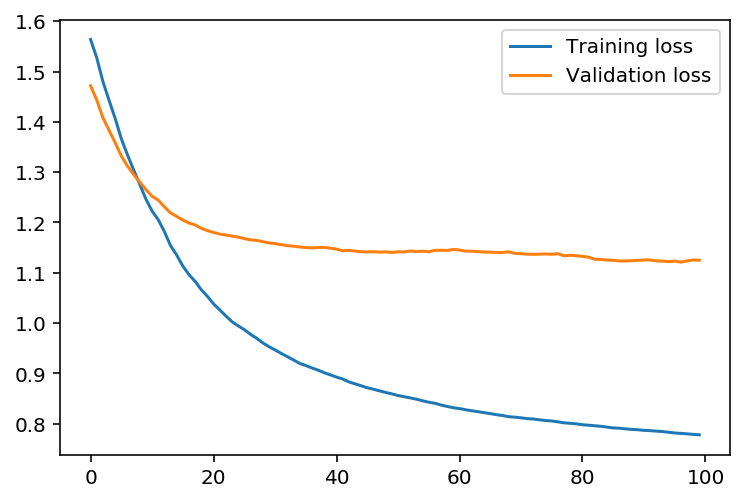

In [175]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

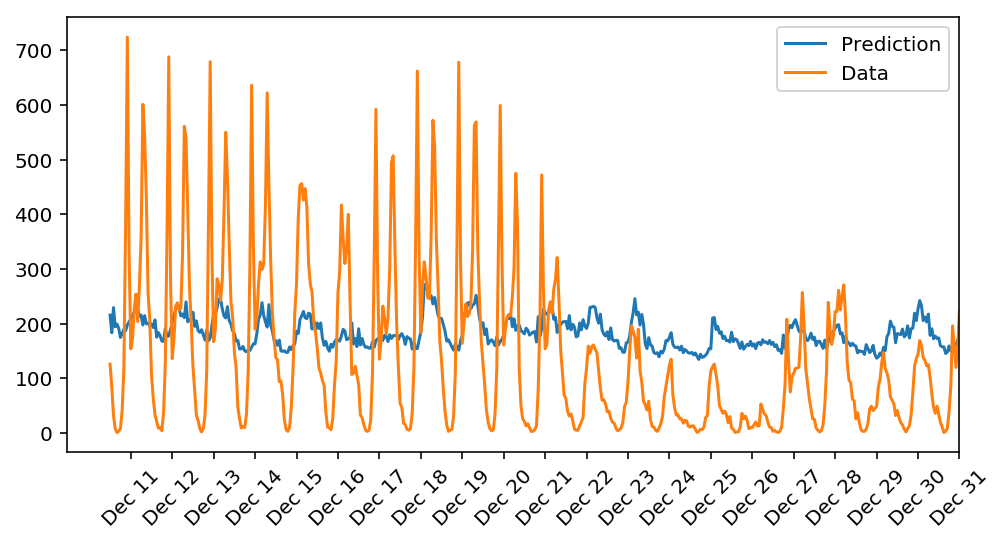

In [176]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
The model doesn't predict well the data, we should use sigmoid function with the output node 